# 48I point source pipi correlation function analysis 

In [2]:
import gpt as g
import qlat_gpt as qg
import qlat as q
import numpy as np
import matplotlib.pyplot as plt
import qlat_utils as qu
from scipy.optimize import curve_fit
from scipy import stats

SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

### Jackknife

In [3]:
#Jackknife functionality

#constructs Ncf jackknife blocks
def jackblocks(data,omit,prt=0):
    #loop over timeslices
    #assuming shape (Ncf,NT)
    jacks = np.zeros(data.shape,dtype=np.complex128)
    nconf=data.shape[0]
    nt=data.shape[1]
    norm=1.0/(nconf-1-len(omit))
    if(prt):print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')
    for j in range(0,nt):
        #
        # sum over configs
        #
        s=0.0
        for i in range(0,nconf):
            if i not in omit:
                s = s + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf):
            if i not in omit:
                jacks[n,j] = s-data[i,j]
                jacks[n,j] *= norm
                n=n+1

    return jacks
                
# jackknife blocks of size bs>=1
def jackblocks_bs(data,bs=1):
    
    jacks=np.zeros([int(data.shape[0]/bs),data.shape[1]])
    nconf=data.shape[0]
    if nconf % bs:
        print("num confs not divisible by block size")
        return
    nt=data.shape[1]
    norm=1.0/(nconf-bs)
    # loop over timeslices
    for j in range(0,nt):
        #
        # sum over configs
        #
        sum=0.0
        for i in range(0,nconf):
            sum = sum + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf,bs):
            jacks[n,j] = sum
            for k in range(bs):
                jacks[n,j] -= data[i+k,j]
            jacks[n,j] *= norm
            n=n+1
            
    return jacks
#
# compute avg and jacknife error from a vector of jacknife blocks
def jack(vec):
    n=vec.shape[0]
    avg=0.0
    # compute average
    for i in range(0,n):
        avg+=vec[i]
    avg = avg/n
    # compute error
    err=0.0
    for i in range(0,n):
        err+=(vec[i]-avg)*(vec[i]-avg)
    err *= (n-1)/n
    err = np.sqrt(err)
    #print(f'{n} blocks, avg+-err= {avg:.4e} +- {err:.4e}')
    return avg, err

### Effective mass and fitting functions

In [3]:
#effective mass calculation using two data points/log definition. This uses only one half of the correlator data. This is for the one term fit function
def eff_mass_2d_ln_half(corr_data):
    ncf = corr_data.shape[0]
    nt = corr_data.shape[1]
    m_data = np.zeros((ncf, nt-2),np.float64)
    E = 0.0
    for cf in range(ncf):
        for t in range(nt-2):
        #E = np.arccosh((C_fold[t] + C_fold[t+2])/(2*C_fold[t+1]))
            E = np.log(corr_data[cf,t]/corr_data[cf,t+1])
            m_data[cf,t] = E

    return m_data

#effective mass calculation using two data points/log definition. This uses only one half of the correlator data. This is for the one term fit function
def eff_mass_2d_ln(corr_data):
    ncf = corr_data.shape[0]
    nt = corr_data.shape[1]
    m_data = np.zeros((ncf, nt//2-2),np.float64)
    E = 0.0
    for cf in range(ncf):
        #fold correlator
        C_fold = np.zeros(nt//2 + 1,np.float64)

        C_fold[0] = corr_data[cf,0]
        C_fold[nt//2] = corr_data[cf,nt//2]
        for t in range(1,nt//2):
            C_fold[t] = (corr_data[cf,t] + corr_data[cf,nt-t])/2 
        
        for t in range(nt//2-2):
        #E = np.arccosh((C_fold[t] + C_fold[t+2])/(2*C_fold[t+1]))
            #E = np.log(corr_data[cf,t]/corr_data[cf,t+1])
            E = np.log(C_fold[t]/C_fold[t+1])
            m_data[cf,t] = E

    return m_data
        

def eff_mass_2d_cosh_half(corr_data):
    ncf = corr_data.shape[0]
    nt = corr_data.shape[1]
    m_data = np.zeros((ncf, nt-2),np.float64)
    E = 0.0
    for cf in range(ncf):
        for t in range(nt-2):
            E = np.arccosh((corr_data[cf,t] + corr_data[cf,t+2])/(2*corr_data[cf,t+1]))
            print(E)
            m_data[cf,t] = E

    return m_data

#Effective mass calculation using three data points and the arccosh definition. This folds the correlator, and uses two data points per measurement
#this is to be used with the two term fit function
def eff_mass_2d_cosh(corr_data):
    ncf = corr_data.shape[0]
    nt = corr_data.shape[1]
    m_data = np.zeros((ncf, nt//2-2),np.float64)
    E = 0.0
    for cf in range(ncf):
        #fold correlator
        C_fold = np.zeros(nt//2 + 1,np.float64)

        C_fold[0] = corr_data[cf,0]
        C_fold[nt//2] = corr_data[cf,nt//2]
        for t in range(1,nt//2):
            C_fold[t] = (corr_data[cf,t] + corr_data[cf,nt-t])/2 
        
        for t in range(nt//2-2):
            E = np.arccosh((C_fold[t] + C_fold[t+2])/(2*C_fold[t+1]))
            m_data[cf,t] = E

    return m_data

In [4]:
def covariance(data, shrinkage=0.1):
    
    nconf,tsize=data.shape
    covmat=np.zeros((tsize,tsize))
    avg = np.average(data,axis=0)
    for n in range(nconf):
        covmat+=np.outer(data[n]-avg,data[n]-avg)
    covmat*=1/nconf
    covmat *= nconf-1

    #shrink toward diagonal
    diag_cov = np.diag(np.diag(covmat))
    covmat_shrunk = (1-shrinkage) * covmat + shrinkage * diag_cov
    
    return avg,covmat_shrunk

In [5]:
#calculate an energy for each configuration
#this function takes in 2d correlator data in shape (N_cf,NT), then calculates the large time separation energy for each configuration
#and returns a 2d array of shape (N_cf,NT/2-1). 
#C(t) = A * exp(-t*E) + A*exp(-(T-t)*E)
def emp_fold(data):
    ncf = data.shape[0]
    nt = data.shape[1]
    E_data = np.zeros((ncf,(nt//2)-3))

    print(nt//2 - 1)
    t = 0
    for cf in range(ncf):
        C = data[cf,:]
        CF = [((C[t] + C[(nt - t) % nt]) / 2) for t in range(nt//2 - 1)]
        E = [np.arccosh((CF[t] + CF[t+2])/2/CF[t+1]) for t in range(0,nt//2 - 3)]

        E_data[cf,:] = E[:]

    return E_data
#jackknife these results to get an energy and error
def pion_model_single(t,A0,E0):
    return A0*np.exp(-E0*t)

def pion_model(t, A0, E0):
    return (A0*np.exp(-E0*t) + A0*np.exp(-(NT-t)*E0))
    #return (np.log(A0) - E0*t)

def pion_model_two_state(t, A0, E0, A1, E1):
    return A0*(np.exp(-E0*t) + np.exp(-(NT-t)*E0)) + A1 * (np.exp(-E1*t) + np.exp(-(NT-t)*E1))

In [6]:
def c2pt_fit_2state(data_jk, fit_range):
    tmin,tmax = fit_range
    npar = 4 # A0, E0, A1, E1
    guess = ([0.2,0.2,0.2,0.2])
    ncf = data_jk.shape[0]
    t_fit = np.arange(tmin, tmax+1)
    csq = np.zeros((ncf))
    corr_avg,corr_err = jack(data_jk)

    dof = tmax - tmin - npar

    popt_avg, pcov_avg = curve_fit(pion_model_two_state,
                              t_fit,
                              corr_avg[tmin:tmax+1],
                              sigma=corr_err[tmin:tmax+1],
                              p0=guess,
                              maxfev=50000)

    param_names = ['A0', 'E0', 'A1', 'E1']
    fit_params = {key: [] for key in param_names}
    params_jk = np.zeros((ncf, npar))

    #fit each jk block
    for jk in range(ncf):
        y_data = data_jk[jk, tmin:tmax+1]
        popt, _  = curve_fit(pion_model_two_state, 
                            t_fit, 
                            y_data,
                            p0 = popt_avg,
                            maxfev=50000)
        for key,value in zip(param_names, popt):
            fit_params[key].append(value)

        params_jk[jk] = popt
        
    fit_errors = {}
    for key in param_names:
        vals = np.array(fit_params[key])
        mean_val, err_val = jack(vals)
        fit_errors[key] = err_val

    theory = pion_model_two_state(t_fit, *popt_avg)
    residuals = corr_avg[tmin:tmax+1] - theory
    chi2 = np.sum((residuals / corr_err[tmin:tmax+1])**2)
    dof = len(t_fit) - npar
    chi2_dof = chi2/dof
    
    F = fdist(dof,ncf-dof)
    p_value = 1 - stats.chi2(dof).cdf(chi2)
    #print('n, chi square, dof=',chi2,dof)
    #print('p-value=',p_value)
    #print("----------------------------------------")

    return popt_avg, fit_errors, fit_params, p_value, chi2_dof
        
    

def c2pt_fit_new(data_jk, fit_range):
    tmin, tmax = fit_range
    ncf = data_jk.shape[0]
    t_fit = np.arange(tmin,tmax+1)

    corr_avg, corr_err = jack(data_jk)

    #calculate covariance matrix
    #fit of the average correlator using the average variance as sigma
    popt_avg, pcov_avg = curve_fit(pion_model,
                                  t_fit,
                                  corr_avg[tmin:tmax+1],
                                  sigma=corr_err[tmin:tmax+1],
                                  p0=[0.1,0.1],
                                  maxfev=50000)

    param_names = ['A0', 'E0']
    fit_params = {key: [] for key in param_names}
    params_jk = np.zeros((ncf,2)) #array to hold params for eahc jackknife block

    #fit of each jackknife block, no weights to generate errors
    for cf in range(ncf):
        y_data = data_jk[cf, tmin:tmax+1]
        popt, _ = curve_fit(pion_model,
                           t_fit,
                           y_data,
                           p0=popt_avg,
                           maxfev=50000)
        for key, value in zip(param_names, popt):
            fit_params[key].append(value)
        
        params_jk[cf] = popt

    fit_errors = {}
    for key in param_names:
        vals = np.array(fit_params[key])
        mean_val, err_val = jack(vals)
        fit_errors[key] = err_val

    #calculate chi squared
    corr_model = pion_model(t_fit, *popt_avg)
    residuals = corr_avg[tmin:tmax+1] - corr_model
    chi2 = np.sum((residuals / np.std(residuals))**2)
    dof = len(t_fit) - 2
    chi2_dof = chi2/dof

    #covariance matrix
    params_cov = np.cov(params_jk.T) * (ncf - 1)

    return popt_avg,fit_errors,fit_params,chi2_dof

# create two state fit for each pion energy to estimate the systematic error via the difference

#covariance matrix in one pion fits


In [7]:
def meson_energy(data_jk, jk_err, tmin,tmax):
    #look at effective mass plot to determine the fit range
    fit_range = (tmin,tmax)

    #generate fit parameters A0, E0 and their errors
    params,err,chi = c2pt_fit(data_jk.real, jk_err.real, fit_range)
    
    A0,E0 = (params[key] for key in ['A0', 'E0'])
    A0_err,E0_err = (err[key] for key in ['A0','E0'])

    #we can do something with the fit here if we need the actual functional form. I'm only after the energy at this point
    return E0,E0_err,A0,A0_err,chi

def meson_energy_new(data_jk, tmin, tmax):
    fit_range = (tmin, tmax)
    popt_avg, fit_errors, fit_params, chi2_dof = c2pt_fit_new(data_jk, fit_range)
    E0 = popt_avg[1]
    E0_err = fit_errors['E0']
    E0_block = fit_params['E0']
    A0 = popt_avg[0]
    A0_err = fit_errors['A0']
    A0_block = fit_params['A0']
    
    return E0, E0_err, E0_block, A0, A0_err, chi2_dof

def meson_energy_2state(data_jk, tmin, tmax):
    fit_range = (tmin, tmax)
    popt_avg, fit_errors, fit_params, p_value, chi2_dof = c2pt_fit_2state(data_jk, fit_range)
    
    A0 = popt_avg[0]
    A0_err = fit_errors['A0']
    A0_block = fit_params['A0']

    E0 = popt_avg[1]
    E0_err = fit_errors['E0']
    E0_block = fit_params['E0']

    A1 = popt_avg[2]
    A1_err = fit_errors['A1']
    A1_block = fit_params['A1']

    E1 = popt_avg[3]
    E1_err = fit_errors['E1']
    E1_block = fit_params['E1']
    
    return A0, A0_err, E0, E0_err, A1, A1_err, E1, E1_err, p_value, chi2_dof

### Momentum projections

In [2382]:
385000*1000 / (1.524/100)

25262467191.60105

In [6]:
#sum over spatial separations, project to momentum space
def wave_function_mode_000(xrel,yrel,zrel,NS):
    w = np.ones_like(xrel)
    return w

#constructs the Fourier component for the (0,0,0) momentum config. 
#inputs are relative coordinates. 
def wave_function_mode_001(xrel,yrel,zrel,NS):
    w1 = np.cos(2.0 * np.pi * xrel / NS)
    w2 = np.cos(2.0 * np.pi * yrel / NS)
    w3 = np.cos(2.0 * np.pi * zrel / NS)
    w = (w1 + w2 + w3)/3.0
    return w

def wave_function_mode_011(xrel,yrel,zrel,NS):
    w1 = np.cos((2.0 * np.pi * xrel / NS) + (2.0 * np.pi * yrel / NS))
    w2 = np.cos((2.0 * np.pi * yrel / NS) + (2.0 * np.pi * zrel / NS))
    w3 = np.cos((2.0 * np.pi * xrel / NS) + (2.0 * np.pi * zrel / NS))
    w4 = np.cos((2.0 * np.pi * xrel / NS) - (2.0 * np.pi * yrel / NS))
    w5 = np.cos((2.0 * np.pi * yrel / NS) - (2.0 * np.pi * zrel / NS))
    w6 = np.cos((2.0 * np.pi * xrel / NS) - (2.0 * np.pi * zrel / NS))
    
    
    w = (w1 + w2 + w3 + w4 + w5 + w6)/6.0
    return w

def wave_function_mode_111(xrel,yrel,zrel,NS):
    w1 = np.cos((2.0 * np.pi * xrel / NS) + (2.0 * np.pi * yrel / NS) + (2.0 * np.pi * zrel / NS))
    w2 = np.cos(-(2.0 * np.pi * xrel / NS) + (2.0 * np.pi * yrel / NS) + (2.0 * np.pi * zrel / NS))
    w3 = np.cos((2.0 * np.pi * xrel / NS) - (2.0 * np.pi * yrel / NS) + (2.0 * np.pi * zrel / NS))
    w4 = np.cos((2.0 * np.pi * xrel / NS) + (2.0 * np.pi * yrel / NS) - (2.0 * np.pi * zrel / NS))
    
    w = (w1 + w2 + w3 + w4)/4.0
    return w

In [7]:
#function that projects out 4d position space correlator into a 1d momentum space correlator. 
#inputs: pos_corr, a 5d array with dim (Ncf, NS, NS, NS, NT). kx,ky,kz: momenta configuration in lattice units i.e. (0,0,1)
def mom_project(pos_corr,mode):
    Ncf,Nx,Ny,Nz,Nt = pos_corr.shape #extent in each direction
    x,y,z = np.meshgrid(np.arange(Nx),np.arange(Ny),np.arange(Nz))

    if mode == 0:
        ph = wave_function_mode_000(x,y,z,Nx)
    elif mode == 1:
        ph = wave_function_mode_001(x,y,z,Nx)
    elif mode == 2:
        ph = wave_function_mode_011(x,y,z,Nx)
    elif mode == 3:
        ph = wave_function_mode_111(x,y,z,Nx)

    mom_corr = np.zeros((Ncf,Nt), np.complex128)

    for cf in range(Ncf):
    #sum over spatial points for each timeslice
        for t in range(Nt):
            pos_arr = pos_corr[cf,:,:,:,t]
                #print(pos_arr.shape)
            mom_corr[cf,t] = np.mean((ph * pos_arr),axis=(0,1,2))

    return mom_corr

## Method 1: Momentum space correlator

### Load in data

In [9]:
dst_1065 = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-meson/traj-1905/meson_corr_psnk_psrc_psel.lat"
ld1065 = q.load_lat_data(dst_1065)
arr1065 = ld1065

In [435]:
q.display_info(ld1005.info())

[['expr_name', 12, ['< 1 >  exprs[0]', '< wf(0) * K_0^dag(0) * K_0(-tsep) >  exprs[1]', '< wf(0) * pi+^dag(0) * pi+(-tsep) >  exprs[2]', '< wf(0) * pi-^dag(0) * pi-(-tsep) >  exprs[3]', '< wf(1) * pi+^dag(0) * pi+(-tsep) >  exprs[4]', '< wf(1) * pi-^dag(0) * pi-(-tsep) >  exprs[5]', '< wf(2) * pi+^dag(0) * pi+(-tsep) >  exprs[6]', '< wf(2) * pi-^dag(0) * pi-(-tsep) >  exprs[7]', '< wf(3) * pi+^dag(0) * pi+(-tsep) >  exprs[8]', '< wf(3) * pi-^dag(0) * pi-(-tsep) >  exprs[9]', '< wf(4) * pi+^dag(0) * pi+(-tsep) >  exprs[10]', '< wf(4) * pi-^dag(0) * pi-(-tsep) >  exprs[11]']], ['t_sep', 96, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '-48', '-47', '-46', '-45', '-44', '-43', '-42', '-41', '-40', '-39', '-38', '-37', '-36', '-35', '-34', '-33', '-32', '-31',

In [16]:
ncf = 100
dst_list = []
prefix = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-meson/"

for cf in range(1005,1096,10):
    dst_list.append(prefix+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1102,1293,10):
    dst_list.append(prefix+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1322,1392,10):
    dst_list.append(prefix+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1412,1492,10):
    dst_list.append(prefix+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1505,1635,10):
    dst_list.append(prefix+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1705,1895,10):
    dst_list.append(prefix+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1905,2026,10):
    dst_list.append(prefix+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(2085,2176,10):
    dst_list.append(prefix+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

In [9]:
len(dst_list)

100

In [17]:
allconf_data = []
ncf = 100
for i in range(ncf):
    #print(i)
    allconf_data.append(q.load_lat_data(dst_list[i]).to_numpy())

In [18]:
full_arr = np.array(allconf_data)

In [12]:
full_arr.shape

(100, 12, 96)

In [1045]:
Ncf = 100
Nexpr = 4
NT = 96
rel_data_000 = np.zeros((Ncf,NT),dtype=np.complex128)
rel_data_001 = np.zeros((Ncf,NT),dtype=np.complex128)
rel_data_011 = np.zeros((Ncf,NT),dtype=np.complex128)
rel_data_111 = np.zeros((Ncf,NT),dtype=np.complex128)

rel_data_000 = full_arr[:Ncf,2,:]
rel_data_001 = full_arr[:Ncf,4,:]
rel_data_011 = full_arr[:Ncf,6,:]
rel_data_111 = full_arr[:Ncf,8,:]

#k = 0
#for i in range(2,9,2):
#    rel_data[:,k,:] =  full_arr[:50,i,:]
#    k = k+1

In [168]:
np.savetxt('psrc_corr_mode000.csv',rel_data_000.real,delimiter=",")
np.savetxt('psrc_corr_mode001.csv',rel_data_001.real,delimiter=",")
np.savetxt('psrc_corr_mode011.csv',rel_data_011.real,delimiter=",")
np.savetxt('psrc_corr_mode111.csv',rel_data_111.real,delimiter=",")

In [166]:
A = np.loadtxt('psrc_corr_mode000.csv',delimiter=",",dtype=np.float64)

In [163]:
rel_data_000[0,0]

np.complex128(0.5465613199521779-2.8632000082015093e-05j)

In [143]:
rel_data_load = np.fromfile('psrc_corr_forMasaaki.bs1')

In [152]:
rel_data_load[2]

np.float64(0.3593151837222268)

In [153]:
rel_data[0,0,1]

np.complex128(0.3593151837222268+9.826851010577324e-05j)

In [138]:
rel_data[0,0,0]

np.complex128(0.5465613199521779-2.8632000082015093e-05j)

In [139]:
allconf_data[0][2,0]

np.complex128(0.5465613199521779-2.8632000082015093e-05j)

In [20]:
x = np.linspace(1,96,95)

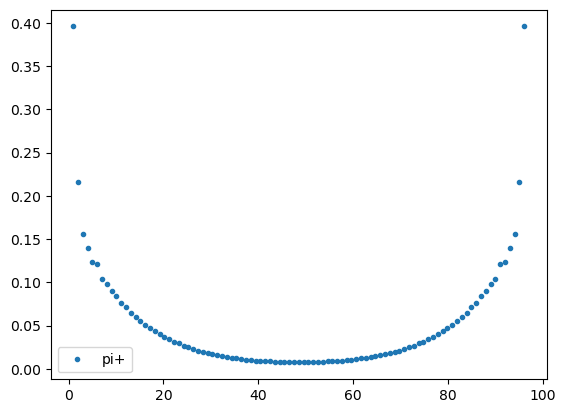

In [21]:
#verify correlator data looks alright
fig1,ax1 = plt.subplots()
#ax1.plot(x,arr975[2,:],'.',label="(0,0,1)")
ax1.plot(x,full_arr[0,2,1:].real,'.',label="pi+")
#ax1.plot(x,arr1005[5,:],'.',label="pi-")
#ax1.plot(x,allconf_data[40][4,:],'.',label="(0,1,1)")
#ax1.plot(x,arr975[4,:],'.',label="(1,1,1)")
#ax1.plot(x,arr975[5,:],'.',label="(0,-1,0)")
#ax1.plot(x,arr975[6,:],'.',label="(0,1,1)")
#ax1.plot(x,arr975[7,:],'.',label="(1,0,1)")
#ax1.plot(x,arr975[8,:],'.',label="(1,1,1)")
#ax1.set_yscale("log")
ax1.legend()
#ax1.set_ylim(0,0.1)

In [470]:
allconf_data[0][4,32]

np.complex128(0.0007646158947313649+3.227045721617933e-06j)

In [471]:
allconf_data[0][5,32]

np.complex128(0.0007646158947313649+3.227045721617933e-06j)

In [356]:
#one config effective mass
def eff_mass(data_1d, NT):
    m = []
    for t in range(1,NT-1):
        m.append(-np.log(data_1d[t].real/data_1d[t-1].real))

    return m

In [18]:
def eff_mass_periodic(data_1d, NT):
    return 0

(0.0, 48.0)

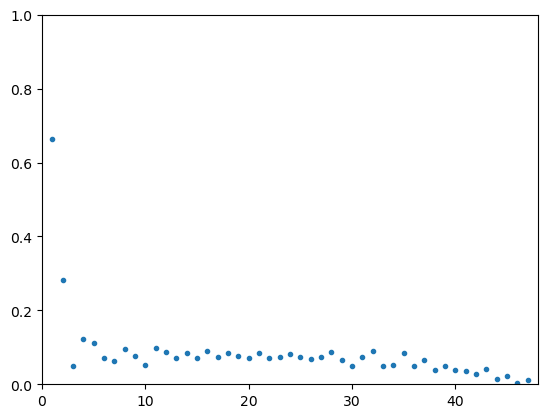

In [384]:
NT = 96
m_1 = eff_mass(arr1065[2,:],NT)
#m_2 = eff_mass(arr1412[1,:],NT)
#m_3 = eff_mass(arr1422[1,:],NT)
#m_4 = eff_mass(arr1432[1,:],NT)
#m_5 = eff_mass(arr1442[1,:],NT)
#m_6 = eff_mass(arr1452[1,:],NT)
#m_7 = eff_mass(arr1462[1,:],NT)
#m_8 = eff_mass(arr1472[1,:],NT)
#m_9 = eff_mass(arr1482[1,:],NT)
#m_10 = eff_mass(arr1492[1,:],NT)

X2 = np.linspace(0,NT-3,NT-2)
fig2, ax2 = plt.subplots()
ax2.plot(X2,m_1,'.',label="(0,0,0)")

ax2.set_ylim(0,1)
ax2.set_xlim(0,48)
#ax2.legend()

### correlation functions

In [14]:
#defining arrays of correlation function data in shape (N_cf, NT) for each momentum mode
N_cf = 100
#ncf_small = 38
NT = 96
arr_pp_000 = np.zeros((N_cf,NT),dtype=np.complex128)
#arr_pp_000_small = np.zeros((ncf_small,NT),dtype=np.complex128)
arr_pp_001 = np.zeros((N_cf,NT),dtype=np.complex128)
arr_pp_011 = np.zeros((N_cf,NT),dtype=np.complex128)
arr_pp_111 = np.zeros((N_cf,NT),dtype=np.complex128)
#arr_pp_exp = np.zeros((N_cf,NT),dtype=np.complex128)

for i in range(N_cf):
    arr_pp_000[i,:] = 0.5*(allconf_data[i][2,:] + allconf_data[i][3,:])
    arr_pp_001[i,:] = 0.5*(allconf_data[i][4,:] + allconf_data[i][5,:])
    arr_pp_011[i,:] = 0.5*(allconf_data[i][6,:] + allconf_data[i][7,:])
    arr_pp_111[i,:] = 0.5*(allconf_data[i][8,:] + allconf_data[i][9,:])
    #arr_pp_exp[i,:] = 0.5*(allconf_data[i][10,:] + allconf_data[i][11,:])

In [15]:
#apply jackknife
omit = []

#j000_small = jackblocks(arr_pp_000_small,omit)
j000 = jackblocks(arr_pp_000,omit)
j001 = jackblocks(arr_pp_001, omit)
j011 = jackblocks(arr_pp_011, omit)
j111 = jackblocks(arr_pp_111, omit)
#jexp = jackblocks(arr_pp_exp,omit)

#pi_000_small_avg, pi_000_small_err = jack(j000_small)
pi_000_avg, pi_000_err = jack(j000)
pi_001_avg, pi_001_err = jack(j001)
pi_011_avg, pi_011_err = jack(j011)
pi_111_avg, pi_111_err = jack(j111)
#pi_exp_avg, pi_exp_err = jack(jexp)

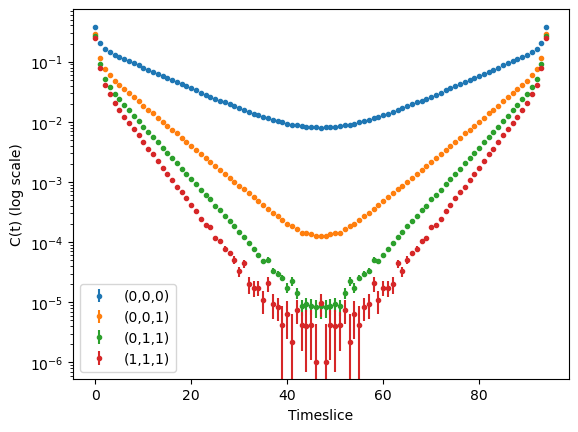

In [16]:
X1 = np.linspace(0,94,95)

fig2, ax2 = plt.subplots()
ax2.errorbar(X1,pi_000_avg[1:].real,yerr=pi_000_err[1:].real,marker=".",ls="",label="(0,0,0)")
ax2.errorbar(X1,pi_001_avg[1:].real,yerr=pi_001_err[1:].real,marker=".",ls="",label="(0,0,1)")
ax2.errorbar(X1,pi_011_avg[1:].real,yerr=pi_011_err[1:].real,marker=".",ls="",label="(0,1,1)")
ax2.errorbar(X1,pi_111_avg[1:].real,yerr=pi_111_err[1:].real,marker=".",ls="",label="(1,1,1)")
#ax2.errorbar(X1,pi_exp_avg[1:].real,yerr=pi_exp_err[1:].real,marker=".",ls="",label="(1,1,1)")
ax2.set_yscale("log")
ax2.set_xlabel("Timeslice")
ax2.set_ylabel("C(t) (log scale)")
ax2.legend();
#fig2.savefig("pion_corr.pdf",bbox_inches="tight")

### Effective energy

In [17]:
#construct the fit function and effective mass for each configuration and timeslice
tmax_000 = 46
tmax_001 = 46
tmax_011 = 46
tmax_111 = 46

em_arr_000 = np.zeros((N_cf,(tmax_000)),dtype=np.complex128)
em_arr_001 = np.zeros((N_cf,(tmax_001)),dtype=np.complex128)
em_arr_011 = np.zeros((N_cf,(tmax_011)),dtype=np.complex128)
em_arr_111 = np.zeros((N_cf,tmax_111),dtype=np.complex128)
#em_arr_exp = np.zeros((N_cf,tmax_111),dtype=np.complex128)

#em_arr_000 = eff_mass_2d(arr_pp_zero.real)
#em_arr_001 = eff_mass_2d(arr_pp_001.real)
#em_arr_011 = eff_mass_2d(arr_pp_011.real)
#em_arr_111 = eff_mass_2d(arr_pp_111.real)

em_arr_000 = eff_mass_2d_ln(j000.real)
#em_arr_000_ln = eff_mass_2d_ln(j000.real)
em_arr_001 = eff_mass_2d_ln(j001.real)
em_arr_011 = eff_mass_2d_ln(j011.real)
em_arr_111 = eff_mass_2d_ln(j111.real)
#em_arr_exp = eff_mass_2d(jexp.real)

#jackknife
omit = []
#em_000_jack = jackblocks(em_arr_000,omit)
#em_001_jack = jackblocks(em_arr_001,omit)
#em_011_jack = jackblocks(em_arr_011,omit)
#em_111_jack = jackblocks(em_arr_111,omit)
#em_000_ln_avg, em_000_ln_err = jack(em_arr_000_ln)
em_000_avg, em_000_err = jack(em_arr_000)
em_001_avg, em_001_err = jack(em_arr_001)
em_011_avg, em_011_err = jack(em_arr_011)
em_111_avg, em_111_err = jack(em_arr_111)
#em_exp_avg, em_exp_err = jack(em_arr_exp)

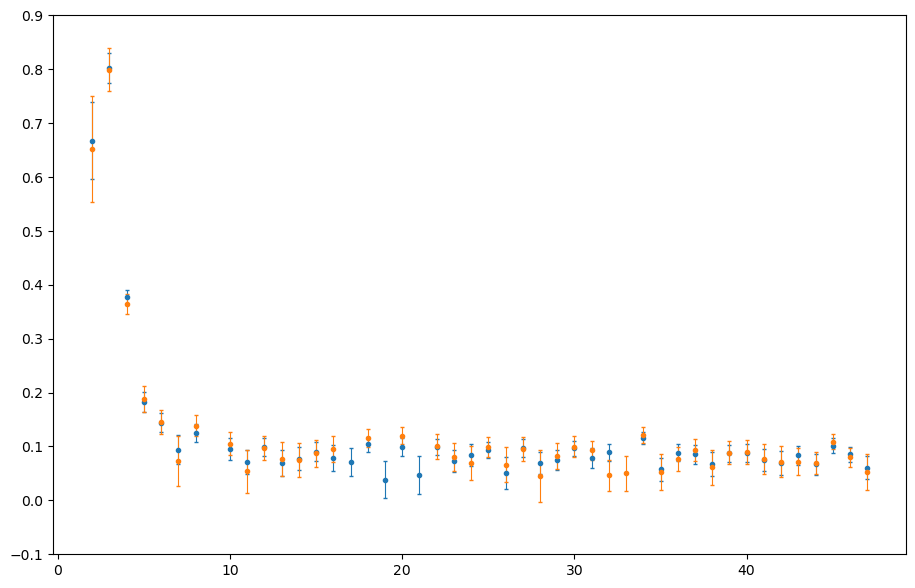

In [218]:
#just 000
fig000, ax000 = plt.subplots(figsize = (11,7))
ax000.errorbar(X3, em_000_avg.real, yerr=em_000_err.real,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="E(0,0,0)")
ax000.errorbar(X3, PSRC_000_em[:46], yerr=PSRC_000_err[:46], marker=".", ls="",elinewidth=0.8,capsize=1.5,label="E(0,0,0)")
ax000.set_ylim(-0.1,0.9)
ax000.set_yticks(np.arange(-0.1,1,0.1));

Text(0.5, 0, 't/a')

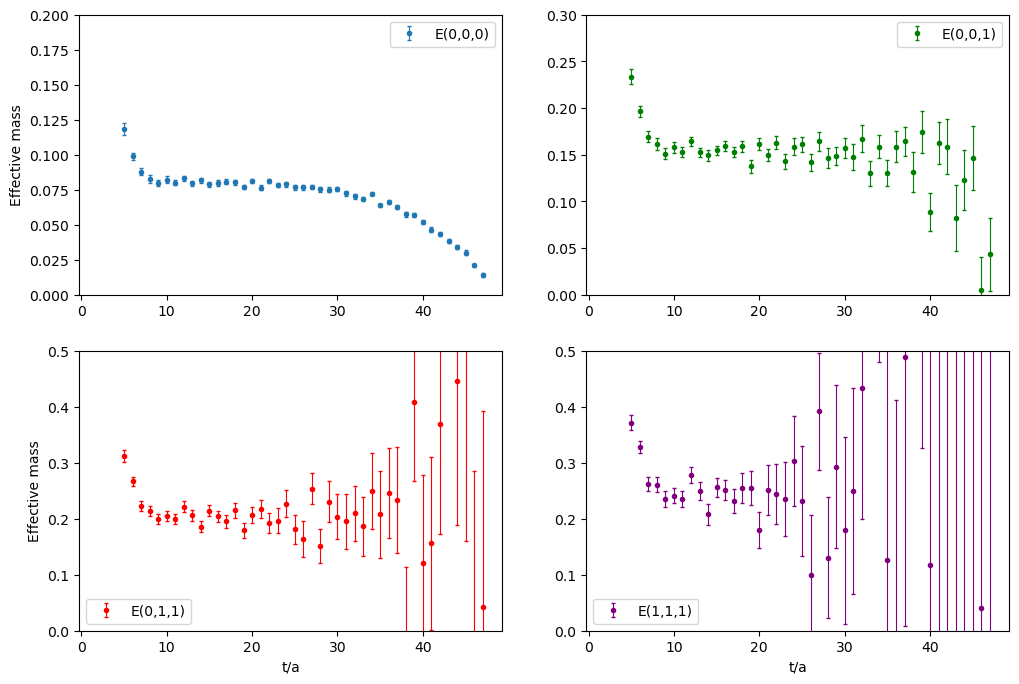

In [19]:
#X3 = np.linspace(1,tmax-1,tmax)
X3 = np.linspace(2,NT//2-1,(NT//2-2))

fig3, ax3 = plt.subplots(2,2, figsize = (12,8))
ax3[0,0].errorbar(X3, em_000_avg.real, yerr=em_000_err.real,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="E(0,0,0)")
ax3[0,1].errorbar(X3, em_001_avg.real, yerr=em_001_err.real,marker=".",color='green',ls="",elinewidth=0.8,capsize=1.5,label="E(0,0,1)")
ax3[1,0].errorbar(X3, em_011_avg.real, yerr=em_011_err.real,marker=".",color = 'red', ls="",elinewidth=0.8,capsize=1.5,label="E(0,1,1)")
ax3[1,1].errorbar(X3, em_111_avg.real, yerr=em_111_err.real,marker=".",color='purple',ls="",elinewidth=0.8,capsize=1.5,label="E(1,1,1)")
#ax3[1,1].errorbar(X3, em_exp_avg.real, yerr=em_exp_err.real,marker=".",color='blue',ls="",elinewidth=0.8,capsize=1.5,label="E(1,1,1)")
#ax3.plot(X3, E_data_111[0,:30],'.')
#ax3.plot(X3, E_data_111[19,:30],'.')

ax3[0,0].set_ylim(0.0,0.2)
ax3[0,1].set_ylim(0.00,0.30)
ax3[1,0].set_ylim(0,0.5)
ax3[1,1].set_ylim(0,.5)

ax3[0,0].legend()
ax3[0,1].legend()
ax3[1,0].legend()
ax3[1,1].legend()

ax3[0,0].set_ylabel("Effective mass")
ax3[1,0].set_ylabel("Effective mass")
ax3[1,0].set_xlabel("t/a")
ax3[1,1].set_xlabel("t/a")

#fig3.savefig("eff_mass.pdf",bbox_inches='tight')

In [20]:
E000, E000_err2, E000_jk, chi2_dof000 = meson_energy_new(j000.real,10,30)
E001, E001_err2, E001_jk, chi2_dof001 = meson_energy_new(j001.real,10,30)
E011, E011_err2, E011_jk, chi2_dof011 = meson_energy_new(j011.real,10,30)
E111, E111_err2, E111_jk, chi2_dof111 = meson_energy_new(j111.real,10,30)

In [96]:
a_inv = 1.73
E000, E000_err, A000, A000_err, chi000 = meson_energy(j000, pi_000_err,10,25)
E001, E001_err, A001, A001_err, chi001 = meson_energy(j001, pi_001_err,10,25)
E011, E011_err, A011, A011_err, chi011 = meson_energy(j011, pi_011_err, 10,25)
E111, E111_err, A111, A111_err, chi111 = meson_energy(j111, pi_111_err, 10,25)

E = [(np.average(np.array(E000))*a_inv)**2, (np.average(np.array(E001))*a_inv)**2, (np.average(np.array(E011))*a_inv)**2, (np.average(np.array(E111))*a_inv)**2]
E_err = [(np.std(np.array(E000))*a_inv), (np.std(np.array(E001))*a_inv), (np.std(np.array(E011))*a_inv), (np.std(np.array(E111))*a_inv)]

In [97]:
E000_avg, E000_err2 = jack(np.array(E000))
E001_avg, E001_err2 = jack(np.array(E001))
E011_avg, E011_err2 = jack(np.array(E011))
E111_avg, E111_err2 = jack(np.array(E111))

In [21]:
print(f"E_000: {E000} +/- {E000_err2}")
print(f"E_001: {E001} +/- {E001_err2}")
print(f"E_011: {E011} +/- {E011_err2}")
print(f"E_111: {E111} +/- {E111_err2}")

E_000: 0.08073496802044046 +/- 0.0001368467388774598
E_001: 0.1537637512164445 +/- 0.00039121438235480675
E_011: 0.20195624410491606 +/- 0.0010255422919984208
E_111: 0.24096660939540768 +/- 0.0022107381935072353


In [1]:
print(f"E_000: {E000_avg} +/- {E000_err2}")
print(f"E_001: {E001_avg} +/- {E001_err2}")
print(f"E_011: {E011_avg} +/- {E011_err2}")
print(f"E_111: {E111_avg} +/- {E111_err2}")

NameError: name 'E000_avg' is not defined

In [22]:
print(f"chi squared 000: {np.average(np.array(chi2_dof000))}")
print(f"chi squared 001: {np.average(np.array(chi2_dof001))}")
print(f"chi squared 011: {np.average(np.array(chi2_dof011))}")
print(f"chi squared 111: {np.average(np.array(chi2_dof111))}")

chi squared 000: 1.1057207734853138
chi squared 001: 1.1098013562161175
chi squared 011: 1.1186985100866216
chi squared 111: 1.1157206142550702


In [1092]:
np.mean(np.array(E000_err))

np.float64(0.00018153701901888746)

In [1677]:
a_inv = 1.730 #GeV
m_pi = .139 #GeV
NS = 48

#E_gs = np.sqrt(m_pi**2)
p_0 = 0.0; 
p_1 = ((2*np.pi*a_inv)/(NS))**2
p_2 = ((2*np.pi*a_inv)/(NS))**2 + ((2*np.pi*a_inv)/(NS))**2
p_3 = ((2*np.pi*a_inv)/(NS))**2 + ((2*np.pi*a_inv)/(NS))**2 + ((2*np.pi*a_inv)/(NS))**2

mode = [p_0,p_1,p_2,p_3]

E_gs = m_pi**2
E001_ac = m_pi**2 + p_1
E011_ac = m_pi**2 + p_2
E111_ac = m_pi**2 + p_3
E_ac = [E_gs, E001_ac,E011_ac,E111_ac]

In [476]:
print(E_A2A)
#print(E)
#print(E_ac)

NameError: name 'E_A2A' is not defined

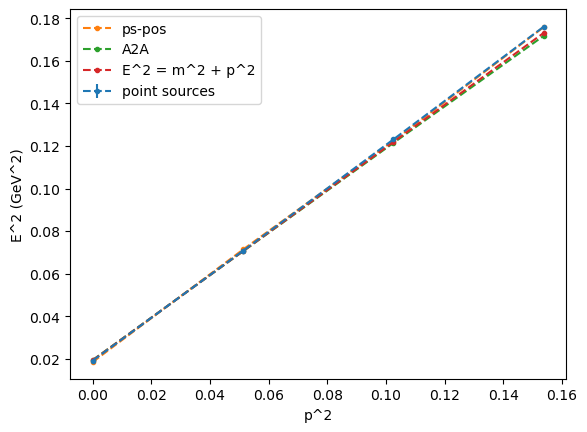

In [1679]:
fig4, ax4 = plt.subplots()
ax4.errorbar(mode, E, yerr=E_err, marker = '.', ls='--',label="point sources")
ax4.plot(mode, Ep2, marker=".",ls="--",label="ps-pos")
ax4.plot(mode, E_A2A_sq, marker = '.', ls='--',label="A2A")
ax4.plot(mode, E_ac,marker='.',ls='--',label="E^2 = m^2 + p^2")
ax4.set_ylabel("E^2 (GeV^2)")
ax4.set_xlabel("p^2")
modes = np.arange(4)
#ax4.set_xticks(modes)
ax4.legend()
#fig4.savefig("dispersion.pdf"); 
#ax4.set_ylim(0.14,0.18)
#ax4.set_xlim(0.12,0.16)


## 48I A2A comparison

In [39]:
fn_000 = "efmpl_momAve_pion2pt000_dt1.bs1"
fn_001 = "efmpl_momAve_pion2pt001_dt1.bs1"
fn_011 = "efmpl_momAve_pion2pt011_dt1.bs1"
fn_111 = "efmpl_momAve_pion2pt111_dt1.bs1"

In [199]:
fn_000_psrc = "efm_cosh3pt_mode000.txt"

In [202]:
PSRC_000_load.shape

(141,)

In [40]:
A2A_000_load = np.fromfile(fn_000, sep=" ")
A2A_001_load = np.fromfile(fn_001, sep=" ")
A2A_011_load = np.fromfile(fn_011, sep=" ")
A2A_111_load = np.fromfile(fn_111, sep=" ")

In [200]:
PSRC_000_load = np.fromfile(fn_000_psrc, sep=" ")

In [206]:
A2A_000_em = np.zeros((NT//2-1), dtype=np.float64)
A2A_000_err = np.zeros((NT//2-1), dtype=np.float64)
A2A_001_em = np.zeros((NT//2-1), dtype=np.float64)
A2A_001_err = np.zeros((NT//2-1), dtype=np.float64)
A2A_011_em = np.zeros((NT//2-1), dtype=np.float64)
A2A_011_err = np.zeros((NT//2-1), dtype=np.float64)
A2A_111_em = np.zeros((NT//2-1), dtype=np.float64)
A2A_111_err = np.zeros((NT//2-1), dtype=np.float64)
PSRC_000_em = np.zeros((NT//2-1), dtype=np.float64)
PSRC_000_err = np.zeros((NT//2-1), dtype=np.float64)
for i in range(48-1):
    A2A_000_em[i] = A2A_000_load[i*3+1]
    A2A_000_err[i] = A2A_000_load[i*3+2]
    
    A2A_001_em[i] = A2A_001_load[i*3+1]
    A2A_001_err[i] = A2A_001_load[i*3+2]
    
    A2A_011_em[i] = A2A_011_load[i*3+1]
    A2A_011_err[i] = A2A_011_load[i*3+2]
    
    A2A_111_em[i] = A2A_111_load[i*3+1]
    A2A_111_err[i] = A2A_111_load[i*3+2]

    PSRC_000_em[i] = PSRC_000_load[i*3+1]
    PSRC_000_err[i] = PSRC_000_load[i*3+2]

In [207]:
PSRC_000_err

array([0.09857073, 0.03944736, 0.01897839, 0.02425828, 0.02283853,
       0.04626478, 0.01879111,        nan, 0.02121598, 0.04018197,
       0.02238423, 0.03105278, 0.03141545, 0.02493997, 0.02459941,
              nan, 0.01631325,        nan, 0.01626402,        nan,
       0.02262096, 0.02631987, 0.03154005, 0.01901643, 0.03234344,
       0.02269958, 0.04793825, 0.02469047, 0.01903646, 0.01772247,
       0.02959608, 0.0321127 , 0.01455859, 0.03313118, 0.02285417,
       0.02051885, 0.03269074, 0.02120314, 0.02282575, 0.02777939,
       0.02903362, 0.02576143, 0.02040639, 0.01411086, 0.01798851,
       0.03325342, 0.01336234])

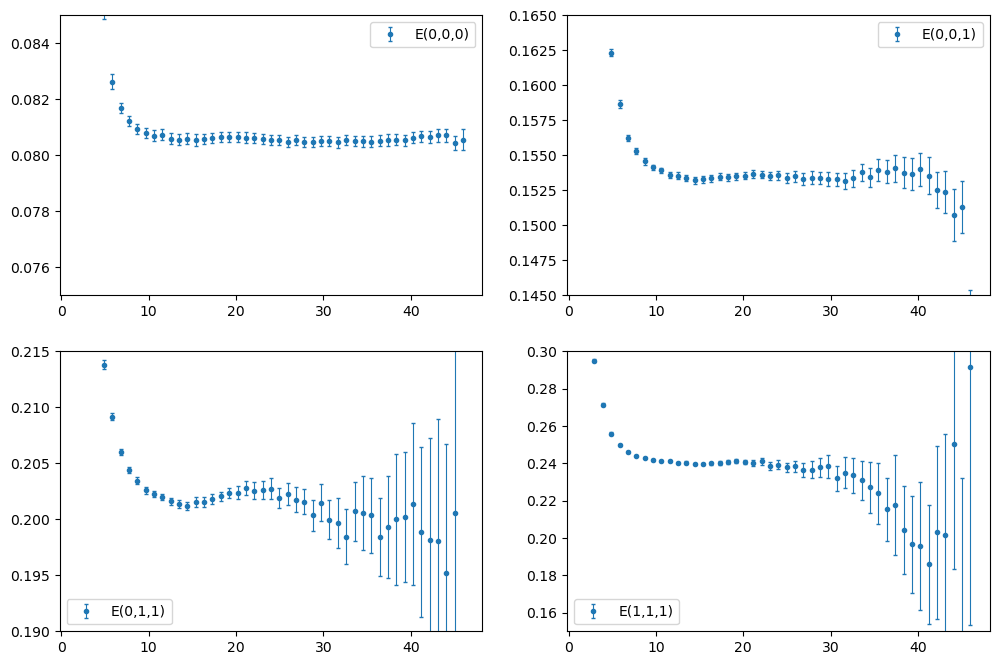

In [42]:
X5 = np.linspace(2,NT//2 - 2,NT//2-1)

fig5, ax5 = plt.subplots(2,2,figsize=(12,8))
ax5[0,0].errorbar(X5, A2A_000_em, yerr=A2A_000_err,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="E(0,0,0)")
ax5[0,1].errorbar(X5, A2A_001_em, yerr=A2A_001_err,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="E(0,0,1)")
ax5[1,0].errorbar(X5, A2A_011_em, yerr=A2A_011_err,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="E(0,1,1)")
ax5[1,1].errorbar(X5, A2A_111_em, yerr=A2A_111_err,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="E(1,1,1)")

ax5[0,0].set_ylim(0.075,0.085)
ax5[0,1].set_ylim(0.145,0.165)
ax5[1,0].set_ylim(0.19,0.215)
ax5[1,1].set_ylim(0.15,0.3)

ax5[0,0].legend()
ax5[0,1].legend()
ax5[1,0].legend()
ax5[1,1].legend()

In [413]:
np.mean(A2A_000_em[10:])

np.float64(0.0805700345945946)

In [92]:
E_A2A = [(np.mean(A2A_000_em[10:])),(np.mean(A2A_001_em[12:40])),(np.mean(A2A_011_em[10:36])),(np.mean(A2A_111_em[8:30]))]
E_A2A_sq = [(a_inv*np.mean(A2A_000_em[10:]))**2,(a_inv*np.mean(A2A_001_em[12:40]))**2,(a_inv*np.mean(A2A_011_em[10:36]))**2,(a_inv*np.mean(A2A_111_em[8:30]))**2]
E_A2A_err = [2*a_inv*np.mean(A2A_000_err[10:]),2*a_inv*np.mean(A2A_001_err[12:40]),2*a_inv*np.mean(A2A_011_err[10:36]),2*a_inv*np.mean(A2A_111_err[8:30])]

In [93]:
E_A2A

[np.float64(0.0805700345945946),
 np.float64(0.15350417142857142),
 np.float64(0.20143994999999998),
 np.float64(0.23960007272727274)]

Text(0.5, 0, 't/a')

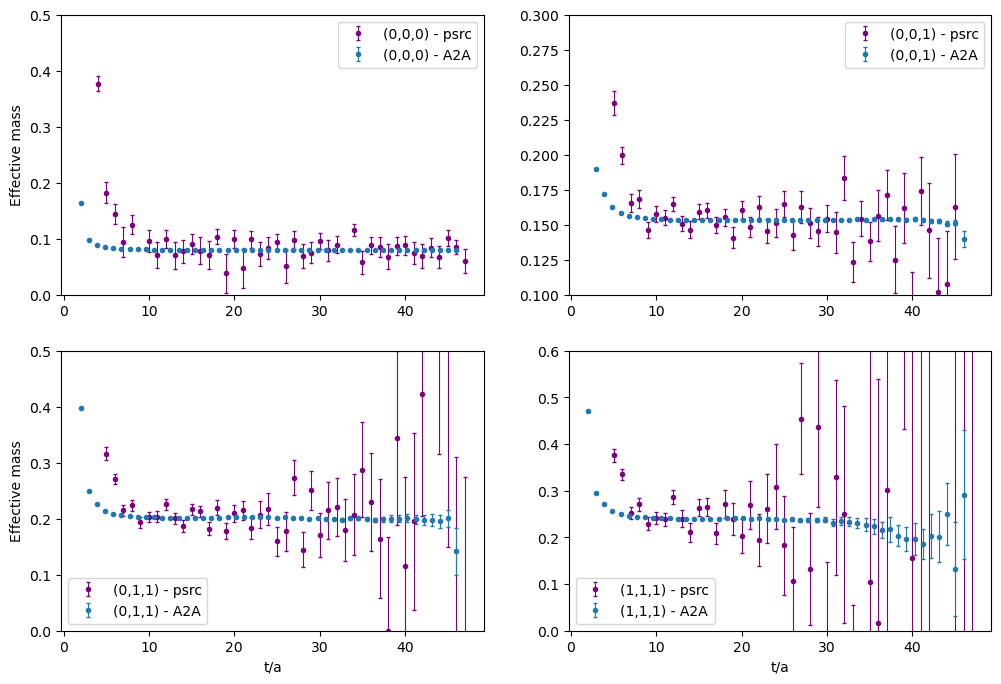

In [195]:
X6 = np.linspace(2,NT//2-1,(NT//2-2))

fig6, ax6 = plt.subplots(2,2, figsize = (12,8))
ax6[0,0].errorbar(X3, em_000_avg.real, yerr=em_000_err.real,marker=".",color='purple',ls="",elinewidth=0.8,capsize=1.5,label="(0,0,0) - psrc")
ax6[0,0].errorbar(X5, A2A_000_em, yerr=A2A_000_err,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="(0,0,0) - A2A")

ax6[0,1].errorbar(X3, em_001_avg.real, yerr=em_001_err.real,marker=".",color='purple',ls="",elinewidth=0.8,capsize=1.5,label="(0,0,1) - psrc")
ax6[0,1].errorbar(X5, A2A_001_em, yerr=A2A_001_err,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="(0,0,1) - A2A")

ax6[1,0].errorbar(X3, em_011_avg.real, yerr=em_011_err.real,marker=".",color = 'purple', ls="",elinewidth=0.8,capsize=1.5,label="(0,1,1) - psrc")
ax6[1,0].errorbar(X5, A2A_011_em, yerr=A2A_011_err,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="(0,1,1) - A2A")

ax6[1,1].errorbar(X3, em_111_avg.real, yerr=em_111_err.real,marker=".",color='purple',ls="",elinewidth=0.8,capsize=1.5,label="(1,1,1) - psrc")
ax6[1,1].errorbar(X5, A2A_111_em, yerr=A2A_111_err,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="(1,1,1) - A2A")
#ax3.plot(X3, E_data_111[0,:30],'.')
#ax3.plot(X3, E_data_111[19,:30],'.')

ax6[0,0].set_ylim(0.00,0.5)
ax6[0,1].set_ylim(0.1,0.3)
ax6[1,0].set_ylim(0.0,0.5)
ax6[1,1].set_ylim(0,0.6)

ax6[0,0].legend()
ax6[0,1].legend()
ax6[1,0].legend()
ax6[1,1].legend()

ax6[0,0].set_ylabel("Effective mass")
ax6[1,0].set_ylabel("Effective mass")
ax6[1,0].set_xlabel("t/a")
ax6[1,1].set_xlabel("t/a")

## Kaon 2pt function

In [985]:
N_cf = 87
arr_k = np.zeros((N_cf,NT),dtype=np.complex128)

for i in range(N_cf):
    arr_k[i,:] = allconf_data[i][1,:]

jkaon = jackblocks(arr_k,omit=[])

kaon_avg, kaon_err = jack(jkaon.real)

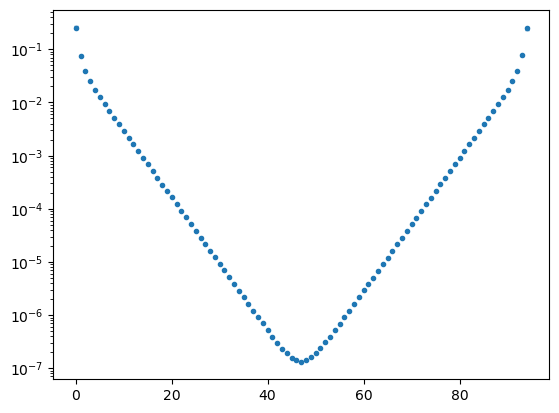

In [986]:
X7 = np.linspace(0,NT-2,NT-1)
fig7, ax7 = plt.subplots()
ax7.errorbar(X7,kaon_avg[1:],yerr=kaon_err[1:],marker=".",ls="",elinewidth=0.8,capsize=1.5,label="gs kaon")
ax7.set_yscale("log")

In [987]:
#effective mass
def eff_mass_kaon(corr_data):
    ncf = corr_data.shape[0]
    nt = corr_data.shape[1]
    m_data = np.zeros((ncf, nt//2),np.float64)
    for cf in range(ncf):
        #fold correlator
        C_fold = np.zeros(nt//2 + 1,np.float64)

        C_fold[0] = corr_data[cf,0]
        C_fold[nt//2] = corr_data[cf,nt//2]
        for t in range(1,nt//2):
            C_fold[t] = (corr_data[cf,t] + corr_data[cf,nt-t])/2 
        
        
        for t in range(1,nt//2-1):
            #E = np.arccosh((C_fold[t] + C_fold[t+2])/(2*C_fold[t+1]))
            E = -np.log(C_fold[t]/C_fold[t-1])
            m_data[cf,t] = E

    return m_data

In [988]:
tmax = 47

em_kaon_arr = np.zeros((N_cf,NT),dtype=np.float64)

em_kaon_arr = eff_mass_kaon(jkaon.real)

em_kaon_avg, em_kaon_err = jack(em_kaon_arr)

(0.2, 0.4)

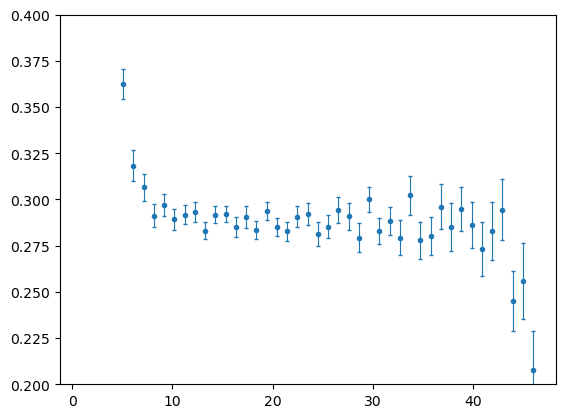

In [989]:
X8 = np.linspace(1,46,45)
fig8,ax8 = plt.subplots()
ax8.errorbar(X8, em_kaon_avg[1:46], yerr=em_kaon_err[1:46],marker=".",ls="",elinewidth=0.8,capsize=1.5,label="gs kaon")
ax8.set_ylim(0.2,0.4)

In [990]:
Ek, Ek_err,A0k, A0k_err, chisq = meson_energy(jkaon,kaon_err,10,28)

In [991]:
Ek_avg,Ek_err = jack(np.array(Ek))

In [992]:
print(f"Kaon effective mass: {Ek_avg} +/- {Ek_err}")
print(f"A_k*A_k: {np.average(np.array(A0k))} +/- {np.average(np.array(A0k_err))}")
print(f"chi squared/d.o.f: {np.average(np.array(chisq))}")

Kaon effective mass: 0.2879699577442976 +/- 0.0003817358860777924
A_k*A_k: 0.06860259277216313 +/- 0.0002872355607198069
chi squared/d.o.f: 0.618868763589594


## Method 2: Full position space pion correlator

### Load data

In [788]:
dst1705 = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos/traj-1705/meson_corr_psnk_psrc_psel.lat"
ld1705 = q.load_lat_data(dst1705)
arr1705 = ld1705.to_numpy()

In [613]:
hold = arr1705.copy()

In [701]:
q.display_info(ld1705.info())

[['x_sep', 48, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '-24', '-23', '-22', '-21', '-20', '-19', '-18', '-17', '-16', '-15', '-14', '-13', '-12', '-11', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1']], ['y_sep', 48, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '-24', '-23', '-22', '-21', '-20', '-19', '-18', '-17', '-16', '-15', '-14', '-13', '-12', '-11', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1']], ['z_sep', 48, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '-24', '-23', '-22', '-21', '-20', '-19', '-18', '-17', '-16', '-15', '-14', '-13', '-12', '-11', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1']], ['t_sep', 96, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'

In [1067]:
ncf = 38
dst_list = []
prefix = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos/"
for cf in range(1102,1292,10):
    dst_list.append(prefix+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1302,1492,10):
    dst_list.append(prefix+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

allconf_pos = []
for i in range(ncf):
    allconf_pos.append(q.load_lat_data(dst_list[i]).to_numpy())

In [703]:
NS = 25
NT = 49
#arr_slice_x = np.zeros(25,dtype=np.complex128)
#acc_t = np.zeros((NS,NS,NS),dtype=np.complex128)
#acc_z = np.zeros((NS,NS),dtype=np.complex128)
#acc_z = np.zeros(NS,dtype=np.complex128)

acc_x = np.mean(np.mean(np.mean(arr1705,axis=3),axis=2),axis=1)
acc_y = np.mean(np.mean(np.mean(arr1705,axis=3),axis=2),axis=0)
acc_z = np.mean(np.mean(np.mean(arr1705,axis=3),axis=1),axis=0)
acc_t = np.mean(np.mean(np.mean(arr1705,axis=2),axis=1),axis=0)

acc_t_75 = np.mean(np.mean(np.mean(arr1705,axis=2),axis=1),axis=0)
#acc_t_75_hold = np.mean(np.mean(np.mean(hold,axis=2),axis=1),axis=0)

#for t in range(49):
#    acc += arr1055[:,:,:,t,1]

#acc /= NT

/nix/store/vzs92vikc2g7i535ma2j6a0gip6axmgw-python3-3.12.11-env/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


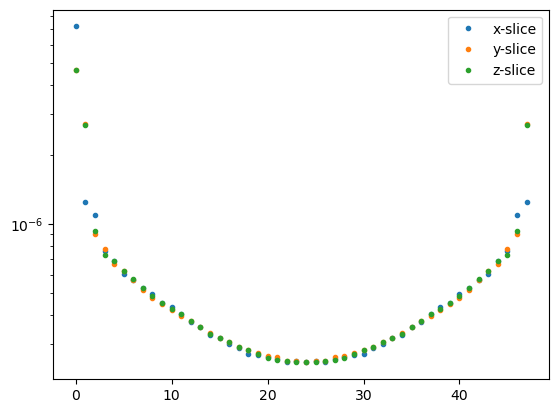

In [705]:
x10 = np.linspace(0,47,48)
fig10, ax10 = plt.subplots()
ax10.plot(x10, acc_x[:,1],'.',label="x-slice")
ax10.plot(x10, acc_y[:,1],'.',label="y-slice")
ax10.plot(x10, acc_z[:,1],'.',label="z-slice")
ax10.set_yscale("log")
ax10.legend();

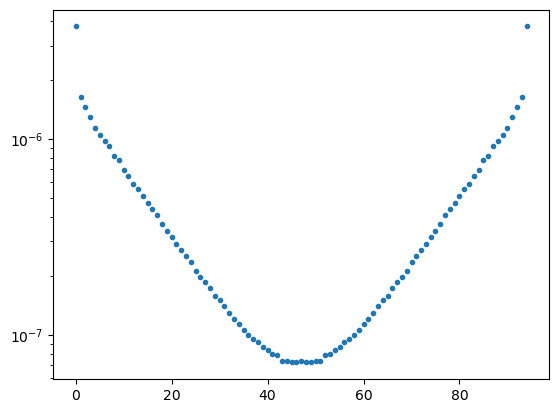

In [708]:
x11 = np.linspace(0,94,95)
fig11, ax11 = plt.subplots()
ax11.plot(x11,acc_t_75[1:,1],'.')
#ax11.plot(x11,acc_t_65[:,2],'.')
ax11.set_yscale("log")

### Effective mass comparison to Method 1

In [1068]:
pos_arr = np.array(allconf_pos)
pp_pos = pos_arr[:,:,:,:,:,1]
pp_freq = pos_arr[:,:,:,:,:,0]

In [1069]:
p000_corr = mom_project(pp_pos,0)
p001_corr = mom_project(pp_pos,1)
p011_corr = mom_project(pp_pos,2)
p111_corr = mom_project(pp_pos,3)

In [1070]:
jp000 = jackblocks(p000_corr,omit=[])
jp001 = jackblocks(p001_corr,omit=[])
jp011 = jackblocks(p011_corr,omit=[])
jp111 = jackblocks(p111_corr,omit=[])

p000_corr_avg, p000_corr_err = jack(jp000.real)
p001_corr_avg, p001_corr_err = jack(jp001.real)
p011_corr_avg, p011_corr_err = jack(jp011.real)
p111_corr_avg, p111_corr_err = jack(jp111.real)

p000_em = eff_mass_2d_ln(jp000.real)
p001_em = eff_mass_2d_ln(jp001.real)
p011_em = eff_mass_2d_ln(jp011.real)
p111_em = eff_mass_2d_ln(jp111.real)

p000_em_avg, p000_em_err = jack(p000_em)
p001_em_avg, p001_em_err = jack(p001_em)
p011_em_avg, p011_em_err = jack(p011_em)
p111_em_avg, p111_em_err = jack(p111_em)

/tmp/ipykernel_3179/514144061.py:93: RuntimeWarning: invalid value encountered in log
  E = np.log(corr_data[cf,t]/corr_data[cf,t+1])


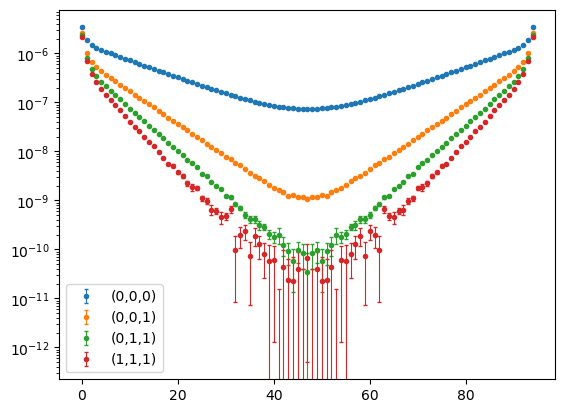

In [1071]:
X16 = np.linspace(0,94,95)
fig16,ax16 = plt.subplots()
ax16.errorbar(X16,p000_corr_avg[1:], yerr=p000_corr_err[1:],marker=".",ls="",elinewidth=0.8,capsize=1.5,label="(0,0,0)")
ax16.errorbar(X16,p001_corr_avg[1:], yerr=p001_corr_err[1:],marker=".",ls="",elinewidth=0.8,capsize=1.5,label="(0,0,1)")
ax16.errorbar(X16,p011_corr_avg[1:], yerr=p011_corr_err[1:],marker=".",ls="",elinewidth=0.8,capsize=1.5,label="(0,1,1)")
ax16.errorbar(X16,p111_corr_avg[1:], yerr=p111_corr_err[1:],marker=".",ls="",elinewidth=0.8,capsize=1.5,label="(1,1,1)")
#ax16.errorbar(X16,q_001_avg,yerr=q_001_err,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="(0,1,1)")
#ax16.errorbar(X16,pos_corr_avg.real,yerr=pos_corr_err.real,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="(0,0,0)")
#ax16.plot(X16,acc_t_75[1:,1],'.',label="(0,0,0)")
#ax16.plot(X16,mc1[1:].real,marker=".",ls="",label="(0,0,1)")
#ax16.plot(X16,mc2.real,marker=".",ls="",label="(0,0,0)")
ax16.set_yscale("log")
ax16.legend();

Text(0.5, 0, 't/a')

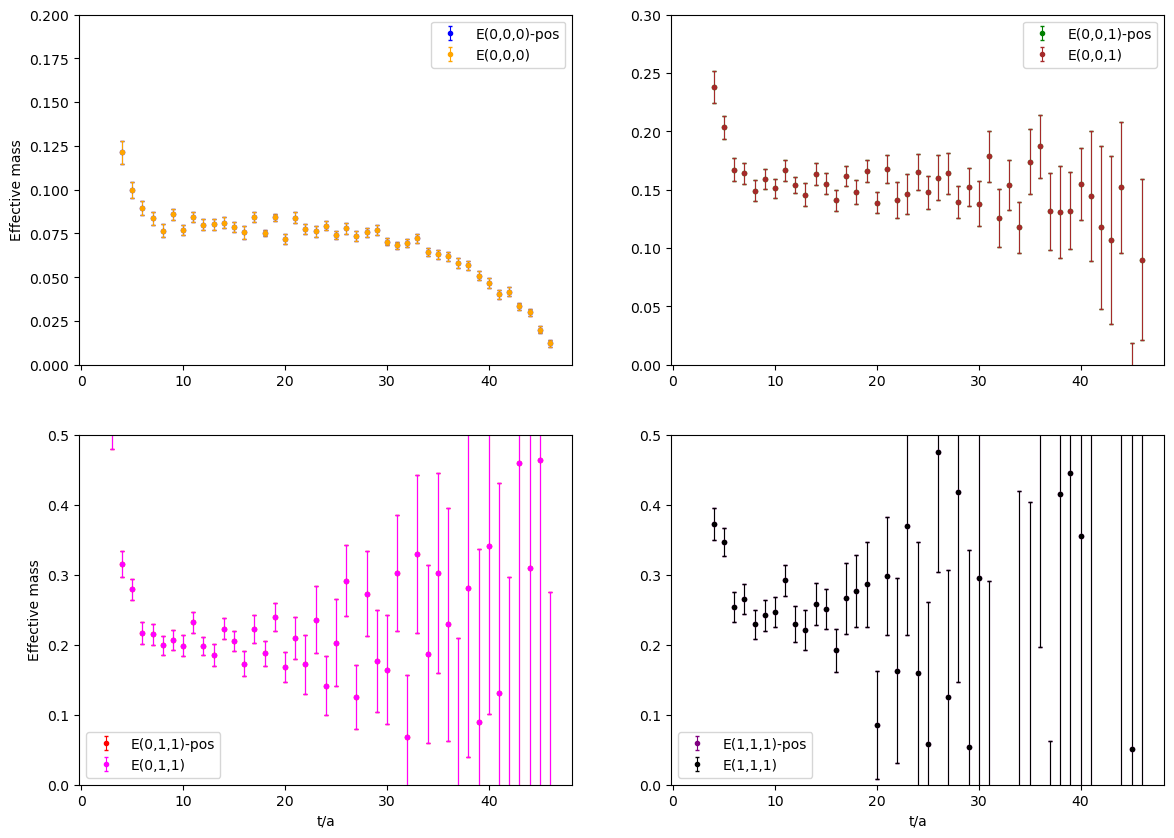

In [1072]:
#X3 = np.linspace(1,tmax-1,tmax)
X3 = np.linspace(2,NT//2-2,(NT//2-3))

fig3, ax3 = plt.subplots(2,2, figsize = (14,10))
ax3[0,0].errorbar(X3, p000_em_avg[1:].real, yerr=p000_em_err[1:].real,marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="E(0,0,0)-pos")
ax3[0,1].errorbar(X3, p001_em_avg[1:].real, yerr=p001_em_err[1:].real,marker=".",color='green',ls="",elinewidth=0.8,capsize=1.5,label="E(0,0,1)-pos")
ax3[1,0].errorbar(X3, p011_em_avg[1:].real, yerr=p011_em_err[1:].real,marker=".",color = 'red', ls="",elinewidth=0.8,capsize=1.5,label="E(0,1,1)-pos")
ax3[1,1].errorbar(X3, p111_em_avg[1:].real, yerr=p111_em_err[1:].real,marker=".",color='purple',ls="",elinewidth=0.8,capsize=1.5,label="E(1,1,1)-pos")

#original method data
ax3[0,0].errorbar(X3, em_000_avg[1:].real, yerr=em_000_err[1:].real,marker=".",color="orange",ls="",elinewidth=0.8,capsize=1.5,label="E(0,0,0)")
ax3[0,1].errorbar(X3, em_001_avg[1:].real, yerr=em_001_err[1:].real,marker=".",color='brown',ls="",elinewidth=0.8,capsize=1.5,label="E(0,0,1)")
ax3[1,0].errorbar(X3, em_011_avg[1:].real, yerr=em_011_err[1:].real,marker=".",color = 'magenta', ls="",elinewidth=0.8,capsize=1.5,label="E(0,1,1)")
ax3[1,1].errorbar(X3, em_111_avg[1:].real, yerr=em_111_err[1:].real,marker=".",color='black',ls="",elinewidth=0.8,capsize=1.5,label="E(1,1,1)")

ax3[0,0].set_ylim(0.0,0.2)
ax3[0,1].set_ylim(0.0,0.3)
ax3[1,0].set_ylim(0.0,0.5)
ax3[1,1].set_ylim(0.0,0.5)

ax3[0,0].legend()
ax3[0,1].legend()
ax3[1,0].legend()
ax3[1,1].legend()

ax3[0,0].set_ylabel("Effective mass")
ax3[1,0].set_ylabel("Effective mass")
ax3[1,0].set_xlabel("t/a")
ax3[1,1].set_xlabel("t/a")

In [1073]:
Ep000, Ep000_err, Ap000, Ap000_err, chip000 = meson_energy(jp000, p000_corr_err,10,18)
Ep001, Ep001_err, Ap001, Ap001_err, chip001 = meson_energy(jp001, p001_corr_err,10,40)
Ep011, Ep011_err, Ap011, Ap011_err, chip011 = meson_energy(jp011, p011_corr_err, 10,24)
Ep111, Ep111_err, Ap111, Ap111_err, chip111 = meson_energy(jp111, p111_corr_err, 10,24)

In [1076]:
Ep000_avg, Ep000_err2 = jack(np.array(Ep000))
Ep001_avg, Ep001_err2 = jack(np.array(Ep001))
Ep011_avg, Ep011_err2 = jack(np.array(Ep011))
Ep111_avg, Ep111_err2 = jack(np.array(Ep111))

In [1077]:
print(f"E_000: {Ep000_avg} +/- {Ep000_err2}")
print(f"E_001: {Ep001_avg} +/- {Ep001_err2}")
print(f"E_011: {Ep011_avg} +/- {Ep011_err2}")
print(f"E_111: {Ep111_avg} +/- {Ep111_err2}")

E_000: 0.0798932505191459 +/- 0.00036237795113496315
E_001: 0.15268948158858073 +/- 0.0005364751612176681
E_011: 0.20182152721680985 +/- 0.0012123513878664215
E_111: 0.24137956513981373 +/- 0.0030536139342001727


In [779]:
print(f"chi squared 000: {np.average(np.array(chip000))}")
print(f"chi squared 001: {np.average(np.array(chip001))}")
print(f"chi squared 011: {np.average(np.array(chip011))}")
print(f"chi squared 111: {np.average(np.array(chip111))}")

chi squared 000: 0.36237898364498194
chi squared 001: 0.8076854180386606
chi squared 011: 0.9955061547728297
chi squared 111: 0.8840920490100088


In [760]:
Ep2 = [np.average(np.array(Ep000))**2*a_inv*a_inv,np.average(np.array(Ep001))**2*a_inv*a_inv,np.average(np.array(Ep011))**2*a_inv*a_inv,np.average(np.array(Ep111))**2*a_inv*a_inv]

In [786]:
np.array(Ep111) - np.array(E111)

array([5.39321593e-06, 4.70265430e-06, 2.23743996e-06, 2.88149158e-06,
       4.33044930e-06, 4.31647430e-06, 4.48436525e-06, 5.59234323e-06,
       4.86429053e-06, 5.23001087e-06, 4.94942922e-06, 2.72831913e-06,
       2.53379113e-06, 3.91819371e-06, 4.71203411e-06, 5.64269559e-06,
       1.35492597e-06, 5.48852832e-06, 3.75861007e-06])

## Method 3: Dividing the correlator by number of values calculated per relative coordinate configuration

In [262]:
#cf = 1492
arr = q.load_lat_data(f"/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old//traj-1302/meson_corr_psnk_psrc_psel.lat").to_numpy()

In [263]:
arr.shape

(25, 25, 25, 49, 2)

In [500]:
dst_list = []
prefix1 = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old/"
prefix2 = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos/"

#for cf in range(1005,1096,10):
#    dst_list.append(prefix1+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(1102,1293,10):
#    dst_list.append(prefix1+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(1322,1392,10):
#    dst_list.append(prefix1+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1102,1493,10):
    dst_list.append(prefix1+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1505,1635,10):
    dst_list.append(prefix1+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1705,2016,10):
    dst_list.append(prefix1+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

dst_list.append(prefix1+f"traj-2025/meson_corr_psnk_psrc_psel.lat")
dst_list.append(prefix1+f"traj-2045/meson_corr_psnk_psrc_psel.lat")
dst_list.append(prefix1+f"traj-2055/meson_corr_psnk_psrc_psel.lat")
dst_list.append(prefix1+f"traj-2065/meson_corr_psnk_psrc_psel.lat")
    
#for cf in range(1905,2026,10):
#    dst_list.append(prefix1+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(2085,2176,10):
    dst_list.append(prefix1+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1005,1096,10):
    dst_list.append(prefix1+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

In [501]:
len(dst_list)

109

In [502]:
dst_list[:50]

['/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old/traj-1102/meson_corr_psnk_psrc_psel.lat',
 '/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old/traj-1112/meson_corr_psnk_psrc_psel.lat',
 '/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old/traj-1122/meson_corr_psnk_psrc_psel.lat',
 '/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old/traj-1132/meson_corr_psnk_psrc_psel.lat',
 '/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old/traj-1142/meson_corr_psnk_psrc_psel.lat',
 '/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old/traj-1152/meson_corr_psnk_psrc_psel.lat',
 '/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old/traj-1162/meson_corr_psnk_psrc_psel.lat',
 '/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old/traj-1172/meson_corr_psnk_psrc_psel.lat',
 '/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-old/traj-1182/meson_corr_psnk_psrc_psel.lat',
 '/home/jhildebrand28/ktopipi/results/48I/auto

In [503]:
ncf = len(dst_list)
allconf_pos_abs = []
for i in range(ncf):
    allconf_pos_abs.append(q.load_lat_data(dst_list[i]).to_numpy()[:,:,:,:,:2])

In [504]:
pp_pos_abs = np.array(allconf_pos_abs)

In [505]:
pp_pos_abs.shape

(109, 25, 25, 25, 49, 2)

In [506]:
pp_pos_delta = pp_pos_abs[:,:,:,:,:,0]
pp_pos_pi = pp_pos_abs[:,:,:,:,:,1]

We have correlator data for each absolute value of relative coordinate between source and sink. Some entries are zero, that is that relative coordinate is not present for the given set of sources and set of sinks (This shouldn't be a problem in the full dataset when we use the full set of sinks). The procedure for averaging over number of occurances is as follows: 

1. Compute the ensemble average over the 4 dimensional coorelator and counter array individually, constructing the jackknife blocks as a ratio of these two arrays.
2. The sum over all relative coordinates has been computed already, in the contraction code. We have both the numerator and denominator of

$$ C(r) = \sum_{j,k}\frac{\langle C(x_j - x_k)\delta(x_j - x_k - r)\rangle}{\delta(x_j - x_k - r)}$$

4. At this point, we have jackknife blocks of a 4d position space correlator averaged over each relative position. We then apply momentum projections to obtain the momentum space correlators. From here we can fit the linear region to extract energies for each momentum mode.

These momentum projections for the excited states require some care, given that we cannot exactly sum over the volume in a traditional way with the data that we have generated. The standard momentum projection looks like 
$$ C(\vec{p},t) = \sum_{\vec{x}} e^{-i\vec{p}\cdot\vec{x}} C(\vec{x},t)
$$

Where we then need to modify this sum to cover the allowed values out correlator takes on, modified by multiplying this value by the multiplicity factorof that given bin of relative coordinates

$$ C(t) = \frac{1}{V}\sum_{\vec{p}}\sum_{x,y,z}^{L/2} M(x,y,z) C_{abs}(x,y,z,t) \cos(\vec{p}\cdot\vec{x})
$$

Where, since we only have access to an octant of the volume, and the full correlator requires a sum over the whole volume, we must include a multiplicity factor $M(x,y,z,t)$ to properly count all possible coordinates that fit into a given bin. 

In [277]:
#given a three element tuple representing any spatial coordinate, this function returns the number of arrangements of actual spatial coordinates that 
#are equivalent to a given absolute value coordinate confguration
def multiplicity(x,y,z):
    if x == 0 and y == 0 and z ==0:
        return 1
    elif (x == 0 and y == 0) or (x == 0 and z == 0) or (y == 0 and z == 0):
        return 2
    elif (x == 0) or (y == 0) or (z == 0):
        return 4
    else:
        return 8
    

In [278]:
def mom_project_half(pos_corr,count_corr,mode):
    Ncf,Nx,Ny,Nz,Nt = pos_corr.shape #extent in each direction
    x,y,z = np.meshgrid(np.arange(Nx),np.arange(Ny),np.arange(Nz))
    #x,y,z = np.meshgrid(np.arange(Nx),np.arange(Ny),np.arange(Nz))
    
    if mode == 0:
        ph = wave_function_mode_000(x,y,z,Nx*2-2)
    elif mode == 1:
        ph = wave_function_mode_001(x,y,z,Nx*2-2)
    elif mode == 2:
        ph = wave_function_mode_011(x,y,z,Nx*2-2)
    elif mode == 3:
        ph = wave_function_mode_111(x,y,z,Nx*2-2)

    #M = np.ones_like(pos_corr[0,:,:,:,:],dtype=int)
    M = np.ones_like(x,dtype=int)
    M = M * (2 - (x==0).astype(int) - (x==24).astype(int))
    M = M * (2 - (y==0).astype(int) - (y==24).astype(int))
    M = M * (2 - (z==0).astype(int) - (z==24).astype(int))
    #M = M * (2 - (t==0).astype(int))

    #M = M * (2 - (x==0).astype(int))
    #M = M * (2 - (y==0).astype(int))
    #M = M * (2 - (z==0).astype(int))
    
    
    #we want to use counters instead of the geometric multiplicity. 
    
    
    mom_corr = np.zeros((Ncf,Nt), np.float64)

    for cf in range(Ncf):
    #sum over spatial points for each timeslice
        for t in range(Nt):
            pos_arr = pos_corr[cf,:,:,:,t]
            count_arr = count_corr[cf,:,:,:,t]
            #mult = M[:,:,:,t]
            #if mode != 0:
            #    phase = ph[:,:,:,t]
            #else:
            #    phase = ph
            mom_corr[cf,t] = np.sum((M * ph * pos_arr),axis=(0,1,2))

    #mom_corr *= ((25*25*25*49)/(48*48*48*96))

    return mom_corr

In [279]:
def jackblocks_ratio(data,counters,omit,prt=0):
    #loop over timeslices
    #assuming shape (Ncf,NT)
    jacks = np.zeros(data.shape,dtype=np.float64)
    nconf=data.shape[0]
    norm=1.0/(nconf-1-len(omit))
    keep_indices = np.setdiff1d(np.arange(nconf),omit)
    data_kept = data[keep_indices,...]
    counters_kept = counters[keep_indices,...]
    if(prt):print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')

    #sum over the config index
    total_data = np.sum(data,axis=0)
    total_counters = np.sum(counters,axis=0)

    jack_num = total_data - data_kept
    jack_den = total_counters - counters_kept

    r = np.zeros_like(jack_num)
    np.divide(jack_num,jack_den,out=jacks,where=jack_den>0)

    return jacks

#check complex
def jack_ratio(blocks):
    n=blocks.shape[0]

    avg = np.mean(blocks,axis=0)

    var = (ncf-1)/ncf

    var *= np.sum((blocks - avg)**2,axis=0)
    err = np.sqrt(var)

    return avg, err

In [529]:
j000_num = jackblocks(pp_pos_pi[:50,:,:,:,:].real,omit=[])
j000_count = jackblocks(pp_pos_delta[:50,:,:,:,:].real,omit=[])

j000_abs = np.zeros_like(j000_num)
j000_abs = np.divide(j000_num,j000_count,where=j000_count>0)

In [513]:
j000_abs.shape

(25, 25, 25, 25, 49)

In [514]:
pp_pos_pi.shape

(109, 25, 25, 25, 49)

In [530]:
p000_abs = mom_project_half(j000_abs.real,j000_count.real,mode=0)
p001_abs = mom_project_half(j000_abs.real,j000_count.real,mode=1)
p011_abs = mom_project_half(j000_abs.real,j000_count.real,mode=2)
p111_abs = mom_project_half(j000_abs.real,j000_count.real,mode=3)

jp000_avg,jp000_err = jack(p000_abs)
jp001_avg,jp001_err = jack(p001_abs)
jp011_avg,jp011_err = jack(p011_abs)
jp111_avg,jp111_err = jack(p111_abs)

In [531]:
np.save("/home/jhildebrand28/ktopipi/single_pion_corr_000", p000_abs)
np.save("/home/jhildebrand28/ktopipi/single_pion_corr_001", p001_abs)
np.save("/home/jhildebrand28/ktopipi/single_pion_corr_011", p011_abs)
np.save("/home/jhildebrand28/ktopipi/single_pion_corr_111", p111_abs)

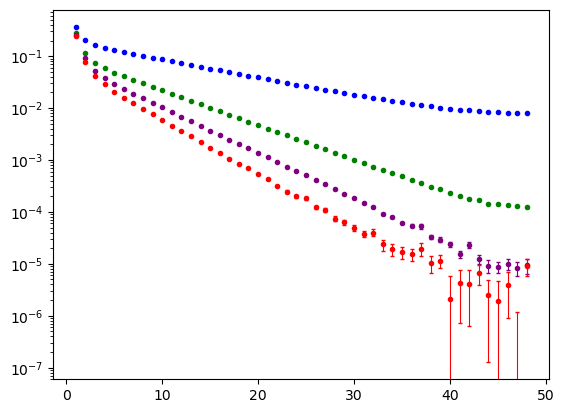

In [283]:
X21 = np.linspace(1,48,48)
fig21, ax21 = plt.subplots()
ax21.errorbar(X21, jp000_avg[1:].real, yerr=jp000_err[1:].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5)
ax21.errorbar(X21, jp001_avg[1:].real, yerr=jp001_err[1:].real, marker=".",color="green",ls="",elinewidth=0.8,capsize=1.5)
ax21.errorbar(X21, jp011_avg[1:].real, yerr=jp011_err[1:].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5)
ax21.errorbar(X21, jp111_avg[1:].real, yerr=jp111_err[1:].real, marker=".",color="red",ls="",elinewidth=0.8,capsize=1.5)
ax21.set_yscale("log")

In [532]:
em_000 = eff_mass_2d_ln_half(p000_abs.real)
em_001 = eff_mass_2d_ln_half(p001_abs.real)
em_011 = eff_mass_2d_ln_half(p011_abs.real)
em_111 = eff_mass_2d_ln_half(p111_abs.real)

em000_avg, em000_err = jack(em_000)
em001_avg, em001_err = jack(em_001)
em011_avg, em011_err = jack(em_011)
em111_avg, em111_err = jack(em_111)

/tmp/ipykernel_1480526/1672590636.py:10: RuntimeWarning: invalid value encountered in log
  E = np.log(corr_data[cf,t]/corr_data[cf,t+1])


In [533]:
np.save("pion_em_000.npy",em_000)
np.save("pion_em_001.npy",em_001)
np.save("pion_em_011.npy",em_011)
np.save("pion_em_111.npy",em_111)

In [376]:
jp000_avg[36]/(np.exp(-E000_avg_t*36) + np.exp(-E000_avg_t*(96 - 36)))

np.float64(0.19329988524673944)

In [1868]:
np.arccosh((p000_abs[4,20] + p000_abs[4,22])/(2*p000_abs[4,21]))

np.float64(0.0872681019217823)

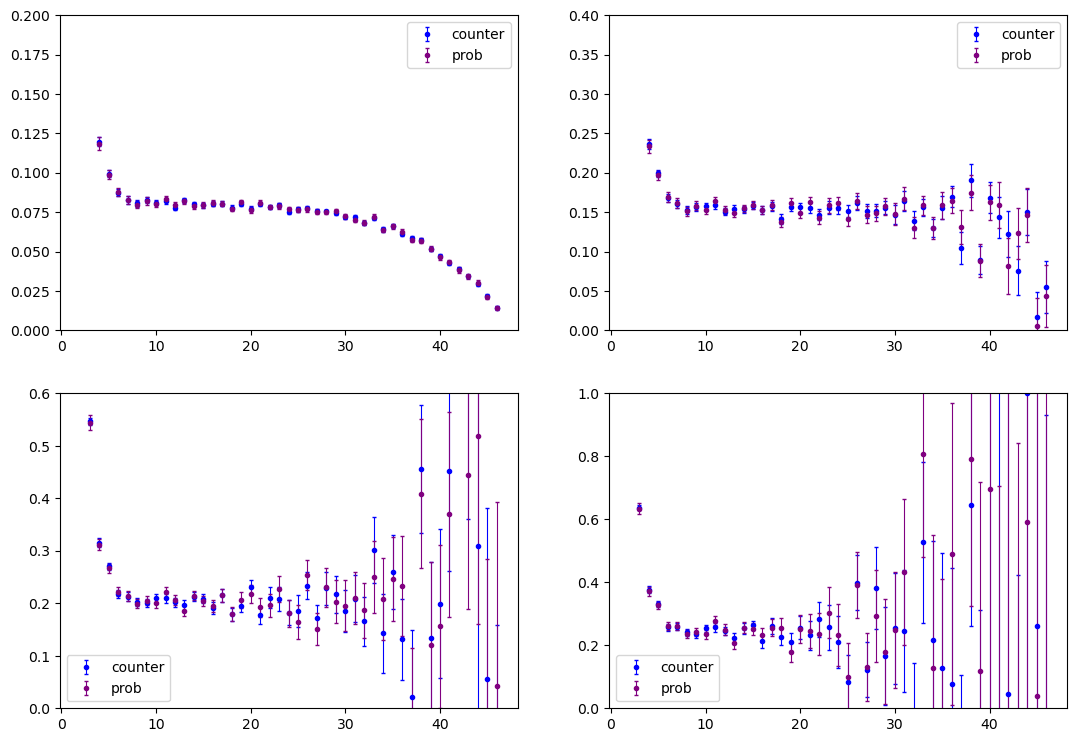

In [285]:
X21 = np.linspace(2,46,45)
fig21, ax21 = plt.subplots(2,2,figsize=(13,9))
ax21[0,0].errorbar(X21, em000_avg[1:46].real, yerr=em000_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="counter")
ax21[0,0].errorbar(X21, em_000_avg[1:46].real, yerr=em_000_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="prob")
ax21[0,0].set_ylim(0,0.2)
ax21[0,0].legend();

ax21[0,1].errorbar(X21, em001_avg[1:46].real, yerr=em001_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="counter")
ax21[0,1].errorbar(X21, em_001_avg[1:46].real, yerr=em_001_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="prob")
ax21[0,1].set_ylim(0.0,0.4)
ax21[0,1].legend();

ax21[1,0].errorbar(X21, em011_avg[1:46].real, yerr=em011_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="counter")
ax21[1,0].errorbar(X21, em_011_avg[1:46].real, yerr=em_011_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="prob")
ax21[1,0].set_ylim(0.0,0.6)
ax21[1,0].legend();

ax21[1,1].errorbar(X21, em111_avg[1:46].real, yerr=em111_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="counter")
ax21[1,1].errorbar(X21, em_111_avg[1:46].real, yerr=em_111_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="prob")
ax21[1,1].set_ylim(0.0,1)
ax21[1,1].legend();

In [99]:
#E000_abs, E000_abs_err, A000, A000_err, chi = meson_energy(p000_abs,jp000_err,10,25)
#E001_abs, E001_abs_err, A001, A001_err, chi = meson_energy(p001_abs,jp001_err,10,25)
#E011_abs, E011_abs_err, A011, A011_err, chi = meson_energy(p011_abs,jp011_err,10,25)
#E111_abs, E111_abs_err, A111, A111_err, chi = meson_energy(p111_abs,jp111_err,10,25)

In [356]:
#one state fits
E000_abs, E000_abs_err, E000_jk, A000_abs, A000_abs_err, chi2_dof = meson_energy_new(p000_abs,10,30)
E001_abs, E001_abs_err, E001_jk, A001_abs, A001_abs_err, chi2_dof = meson_energy_new(p001_abs,10,30)
E011_abs, E011_abs_err, E011_jk, A011_abs, A011_abs_err, chi2_dof = meson_energy_new(p011_abs,10,30)
E111_abs, E111_abs_err, E111_jk, A111_abs, A111_abs_err, chi2_dof = meson_energy_new(p111_abs,10,30)
#E000_avg, E000_err2, E000_jk, chi2_dof = meson_energy_new(j000.real,10,30)

In [470]:
#two state fits
A000_abs2, A000_abs2_err, E000_abs2, E000_err2, A1000_abs2, A1000_abs2_err, E1000_abs2, E1000_abs2_err, p_value, chi2 = meson_energy_2state(p000_abs, 10,30)
A001_abs2, A001_abs2_err, E001_abs2, E001_err2, A1001_abs2, A1001_abs2_err, E1001_abs2, E1001_abs2_err, p_value, chi2 = meson_energy_2state(p001_abs, 10,30)
A011_abs2, A011_abs2_err, E011_abs2, E011_err2, A1011_abs2, A1011_abs2_err, E1011_abs2, E1011_abs2_err, p_value, chi2 = meson_energy_2state(p011_abs, 10,30)
A111_abs2, A111_abs2_err, E111_abs2, E111_err2, A1111_abs2, A1111_abs2_err, E1111_abs2, E1111_abs2_err, p_value, chi2 = meson_energy_2state(p111_abs, 10,30)

/tmp/ipykernel_1480526/443472247.py:29: RuntimeWarning: overflow encountered in exp
  return A0*(np.exp(-E0*t) + np.exp(-(NT-t)*E0)) + A1 * (np.exp(-E1*t) + np.exp(-(NT-t)*E1))
/tmp/ipykernel_1480526/443472247.py:29: RuntimeWarning: invalid value encountered in add
  return A0*(np.exp(-E0*t) + np.exp(-(NT-t)*E0)) + A1 * (np.exp(-E1*t) + np.exp(-(NT-t)*E1))


In [461]:
A1000_abs2

np.float64(0.4307787413547693)

In [475]:
print(f"E0_000: {E000_abs2} +/- {E000_err2}, A0_000: {A000_abs2} +/- {A000_abs2_err},  E1_000: {E1000_abs2} +/- {E1000_abs2_err}")
print(f"E0_001: {E001_abs2} +/- {E001_err2}, A0_001: {A001_abs2} +/- {A001_abs2_err},   E1_001: {E1001_abs2} +/- {E1001_abs2_err}")
print(f"E0_011: {E011_abs2} +/- {E011_err2},  A0_011: {A011_abs2} +/- {A011_abs2_err},   E1_011: {E1011_abs2} +/- {E1011_abs2_err}")
print(f"E0_111: {E111_abs2} +/- {E111_err2}, A0_111: {A111_abs2} +/- {A111_abs2_err}, E1_111: {E1111_abs2} +/- {E1111_abs2_err}")

E0_000: 0.8636857912764904 +/- 45.00651974792906, A0_000: 0.4337170844199102 +/- 2.325906497687005e+38,  E1_000: 0.08067698719282233 +/- 0.0001809327124989141
E0_001: 0.1536805043975041 +/- 0.00042757631895573226, A0_001: 0.09246161233639688 +/- 0.0009587913303171192,   E1_001: 0.15368110045740374 +/- 13.593849098500666
E0_011: 0.5968180834418179 +/- 0.5727002421954303,  A0_011: 0.07770574325022571 +/- 0.08965343995829365,   E1_011: 0.200571599271301 +/- 0.007041307335678536
E0_111: 0.24022382367503128 +/- 0.0019431051564071668, A0_111: -0.060782097347663745 +/- 0.0009025829879412083, E1_111: 0.24022371372627185 +/- 0.0019439835358020336


In [472]:
print(f"E000 stat: {E000_err2}, E000 sys: {np.abs(E000_abs2 - E000_abs)}")
print(f"E001 stat: {E001_err2}, E001 sys: {np.abs(E001_abs2 - E001_abs)}")
print(f"E011 stat: {E011_err2}, E011 sys: {np.abs(E011_abs2 - E011_abs)}")
print(f"E111 stat: {E111_err2}, E111 sys: {np.abs(E111_abs2 - E111_abs)}")

E000 stat: 45.00651974792906, E000 sys: 0.7829892962770555
E001 stat: 0.00042757631895573226, E001 sys: 5.581640971641377e-08
E011 stat: 0.5727002421954303, E011 sys: 0.3952396535228452
E111 stat: 0.0019431051564071668, E111 sys: 1.5763574634508615e-07


In [445]:
print(f"E000 = {E000_abs2:.5f}(18)(02)")
print(f"E001 = {E001_abs2:.5f}(37)(370)")
print(f"E011 = {E011_abs2:.4f}(70)(10)")
print(f"E111 = {E111_abs2:.4f}(21)(47)")

E000 = 0.08068(18)(02)
E001 = 0.15744(37)(370)
E011 = 0.2006(70)(10)
E111 = 0.2354(21)(47)


In [288]:
np.save("/home/jhildebrand28/ktopipi/pion_mass_jk.npy",E000_abs_jk)

In [370]:
E000_avg_t, E000_err_t = jack(np.array(E000_abs_jk))

In [358]:
print(f"E000: {E000_abs} +/- {E000_abs_err}")
print(f"E001: {E001_abs} +/- {E001_abs_err}")
print(f"E011: {E011_abs} +/- {E011_abs_err}")
print(f"E111: {E111_abs} +/- {E111_abs_err}")

E000: 0.08069649499943483 +/- 0.00013045183584066596
E001: 0.15368056021391382 +/- 0.0003707175720010292
E011: 0.2015784299189727 +/- 0.0009103114668704608
E111: 0.24022366603928494 +/- 0.0019448306041026148


In [457]:
print(f"A000: {A000_abs} +/- {A000_abs_err}")
print(f"A001: {np.sqrt(2*E000_abs*A001_abs)} +/- {A001_abs_err}")
print(f"A011: {np.sqrt(2*E000_abs*A011_abs)} +/- {A011_abs_err}")
print(f"A111: {np.sqrt(2*E000_abs*A111_abs)} +/- {A111_abs_err}")

A000: 0.1929578939215526 +/- 0.0009061073423175937
A001: 0.1278501485227394 +/- 0.0007504252110118701
A011: 0.11133396938535026 +/- 0.001114219578249696
A111: 0.10190060482729905 +/- 0.001724588205506099


In [57]:
print(f"E_000: {E000} +/- {E000_err2}")
print(f"E_001: {E001} +/- {E001_err2}")
print(f"E_011: {E011} +/- {E011_err2}")
print(f"E_111: {E111} +/- {E111_err2}")

E_000: 0.08073496802044046 +/- 0.0001368467388774598
E_001: 0.1537637512164445 +/- 0.00039121438235480675
E_011: 0.20195624410491606 +/- 0.0010255422919984208
E_111: 0.24096660939540768 +/- 0.0022107381935072353


In [1775]:
print(f"E_000: {np.sqrt(E_ac[0])/a_inv}")
print(f"E_001: {np.sqrt(E_ac[1])/a_inv}")
print(f"E_011: {np.sqrt(E_ac[2])/a_inv}")
print(f"E_111: {np.sqrt(E_ac[3])/a_inv}")

E_000: 0.08034682080924856
E_001: 0.15359147592609382
E_011: 0.2018045374617682
E_111: 0.24054064355771682


In [1927]:
E_pos = np.array([E000_abs_avg, E001_abs_avg, E011_abs_avg, E111_abs_avg])
E_pos_err = np.array([E000_abs_err2, E001_abs_err2, E011_abs_err2, E111_abs_err2])
E_mom = np.array([E000_avg,E001_avg,E011_avg,E111_avg])
E_mom_err= np.array([E000_err2,E001_err2,E011_err2,E111_err2])

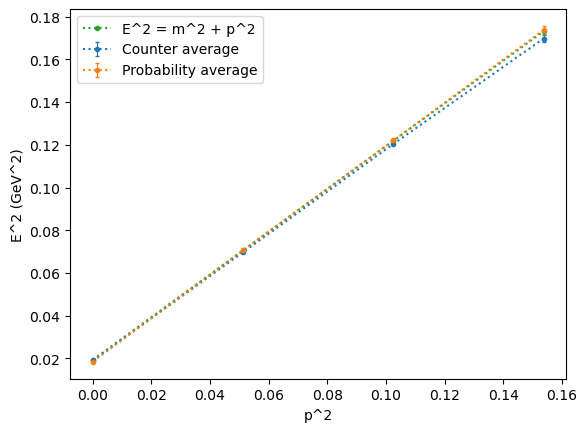

In [1929]:
fig22, ax22 = plt.subplots()
ax22.errorbar(mode, (E_pos*a_inv)**2, yerr=E_pos_err, marker = '.', ls=':',elinewidth=0.8,capsize=1.5,label="Counter average")
ax22.errorbar(mode, (E_mom*a_inv)**2, yerr=E_mom_err, marker = '.', ls=':',elinewidth=0.8,capsize=1.5,label="Probability average")
ax22.plot(mode, E_ac,marker='.',ls=':',label="E^2 = m^2 + p^2")
ax22.set_ylabel("E^2 (GeV^2)")
ax22.set_xlabel("p^2")
modes = np.arange(4)
#ax4.set_xticks(modes)
ax22.legend()

(1.0, 1.1)

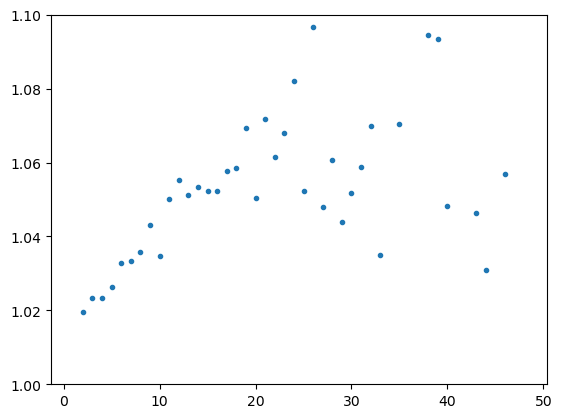

In [2071]:
#ratio of correlators for each method. 
X26 = np.linspace(1,48,48)
R = (jp011_avg[1:].real)/(pi_011_avg[1:49].real)

fig26, ax26 = plt.subplots()
ax26.plot(X26,R,'.')
ax26.set_ylim(1.0,1.1)

### Method 4: hypercubic rotational symmetry

Method 3 uses symmetry to cut down the amount of data we need to look at in each bin, using the absolute value of each relative coordinate as the dimensions of the correlator data. This uses the fact that relative separation (1,1,1,1) is equivalent to (-1,1,1,1). We can expand the amount of symmetry we use by including discrete rotations, that is averaging the current correlator data over relative separations that are equivalent under rotations. That is, for example (1,1,2,1) would be equivalent to (1,2,1,1). This can be implemented by averaging over these equivalent coordinate configurations for the correlator data AND the counter array, then going through the analysis procedure that we saw for method 3. 

In [2003]:
pp_pos_pi[0,1,2,2,15]

np.complex128(1.658499979327427e-05+2.065381705293785e-07j)

In [203]:
#function that takes in the position space correlator data and converts it into a data set for which we average over equivalent positions under hypercubic rotations
def condense(data_full):
    #we want to iterate through the spatial components of the data array , sorting said indices, and averaging over the entries that share this sorted configuratin
    ncf = data_full.shape[0]
    N = data_full.shape[1]
    Nt = data_full.shape[-1]

    #data_4d = data_full[0,:,:,:,:]

    x,y,z = np.meshgrid(np.arange(N),np.arange(N),np.arange(N))

    #stack these three into a single array 
    coords = np.stack((x,y,z),axis=-1)

    #sort the coordinates along our new axis. This holds multuple repeats, each repeat represents a spatial configuration that is equivalent under hypercubic rotations
    sort_coords = np.sort(coords,axis=-1)

    #flatten the array (necessary for np.unique)
    flat_coords = sort_coords.reshape(N*N*N,3)
    flat_data = data_full.reshape(ncf,N*N*N,Nt) #for each config? 
    
    #we want the unique entries, their index, and the number of times each unique thing occurs
    bins, bin_idx, bin_counts = np.unique(flat_coords,axis=0,return_inverse=True,return_counts=True)

    num_bins = bins.shape[0]

    summed_corr = np.zeros((ncf,num_bins,Nt),np.float64)
    counter = np.zeros((ncf,num_bins,Nt),np.int32)

    #we iterate over the number of bins, summing entries in the data array for each bin, and dividing by the number of times the bin shows up
    for bidx in range(num_bins):
        idx_in = np.asarray(bin_idx == bidx).nonzero()[0] #tells us where the bin_idk is equal to some specified index
        idx_in_w = np.where(bin_idx == bidx)[0] #returns a 1D array filled with indices for which the current bin is active

        #we want to fill two arrays of the same shape, one holds values the other counters
        counter[:,bidx,:] = len(idx_in) 
        summed_corr[:,bidx,:] = np.sum(flat_data[:,idx_in,:].real,axis=1)

    #this array is of shape (ncf, nbin, nt). We want to cast these back into a full
    #array of shape (ncf, N,N,N,Nt) to use in the momentum projection functions
    avg_corr = np.divide(summed_corr, counter, where=counter>0)
    
    return avg_corr, bins, bin_idx

'''
I think the error at this point is we are systematically overcounting if there are sites that aren't sampled, they are included in the average and we include the full geometric
multiplicity when we should be doing a multiplicity based on points sampled. This is if there are certain relative momenta configurations that 
'''

#function that calculates the multiplicity of one spatial coordinate configuration
#only coordinate permutations - sign flips are accounted for outside of this
def binned_multiplicity(a,b,c):
    nperm = 0
    nsgn = 0
    if a == b == c:
        nperm = 1
    elif a == b or b == c or a == c:
        nperm = 3
    else:
        nperm = 6

    nsgn = (1 if (a==0 or a==24) else 2) * (1 if (b==0 or b==24) else 2) * (1 if (c==0 or c==24) else 2)
    
    return nsgn*nperm
    

def sym_project(symm_arr, bins, mode):
    NS = 48
    M = np.array([binned_multiplicity(*b) for b in bins])

    x = bins[:,0]
    y = bins[:,1]
    z = bins[:,2]

    #bins has shape (n_bin, 3), where the 3 is for each spatial coordinate
    #they are sorted such that z >= y >= x
    if mode == 0:
        ph = wave_function_mode_000(x,y,z,NS)
    elif mode == 1:
        ph = wave_function_mode_001(x,y,z,NS)
    elif mode == 2:
        ph = wave_function_mode_011(x,y,z,NS)
    elif mode == 3:
        ph = wave_function_mode_111(x,y,z,NS)

    N = 1.0
    #N = 1/(NS*NS*NS) 
    
    #ph and M have the shape of the number of bins
    bin_weight = N * ph * (M)

    mom_corr = np.einsum('cbt,b->ct',symm_arr,bin_weight)
    
    return mom_corr

In [170]:
binned_multiplicity(2,1,23)

48

In [172]:
sym_corr_full, bins, bidx = condense(pp_pos_pi)
sym_counter_full, bins, bidx = condense(pp_pos_delta)

In [204]:
jsym_num = jackblocks(sym_corr_full,omit=[])
jsym_count = jackblocks(sym_counter_full, omit=[])

jsym = np.zeros_like(jsym_num)
jsym = np.divide(jsym_num,jsym_count,where=jsym_count>0)
#jsym = jackblocks_ratio(sym_corr_full, sym_counter_full, omit=[])

In [205]:
sym_000 = sym_project(jsym.real, bins, 0)
sym_001 = sym_project(jsym.real, bins, 1)
sym_011 = sym_project(jsym.real, bins, 2)
sym_111 = sym_project(jsym.real, bins, 3)

sym_000_avg, sym_000_err = jack(sym_000)
sym_001_avg, sym_001_err = jack(sym_001)
sym_011_avg, sym_011_err = jack(sym_011)
sym_111_avg, sym_111_err = jack(sym_111)

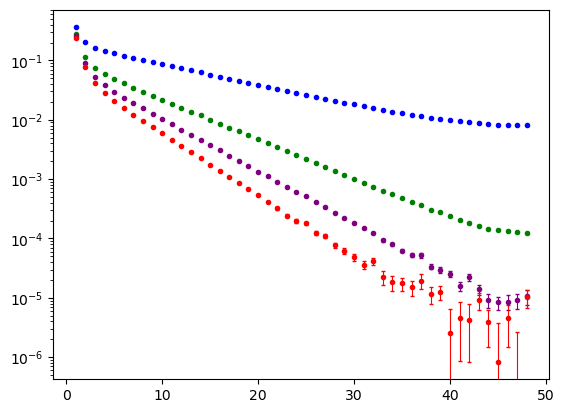

In [206]:
X30 = np.linspace(1,48,48)
fig30, ax30 = plt.subplots()
ax30.errorbar(X30, sym_000_avg[1:].real, yerr=sym_000_err[1:].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5)
ax30.errorbar(X30, sym_001_avg[1:].real, yerr=sym_001_err[1:].real, marker=".",color="green",ls="",elinewidth=0.8,capsize=1.5)
ax30.errorbar(X30, sym_011_avg[1:].real, yerr=sym_011_err[1:].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5)
ax30.errorbar(X30, sym_111_avg[1:].real, yerr=sym_111_err[1:].real, marker=".",color="red",ls="",elinewidth=0.8,capsize=1.5)
ax30.set_yscale("log")

In [129]:
em_sym_000 = eff_mass_2d_ln_half(sym_000)
em_sym_001 = eff_mass_2d_ln_half(sym_001)
em_sym_011 = eff_mass_2d_ln_half(sym_011)
em_sym_111 = eff_mass_2d_ln_half(sym_111)

em_sym_000_avg, em_sym_000_err = jack(em_sym_000)
em_sym_001_avg, em_sym_001_err = jack(em_sym_001)
em_sym_011_avg, em_sym_011_err = jack(em_sym_011)
em_sym_111_avg, em_sym_111_err = jack(em_sym_111)

/tmp/ipykernel_1480526/1672590636.py:10: RuntimeWarning: invalid value encountered in log
  E = np.log(corr_data[cf,t]/corr_data[cf,t+1])


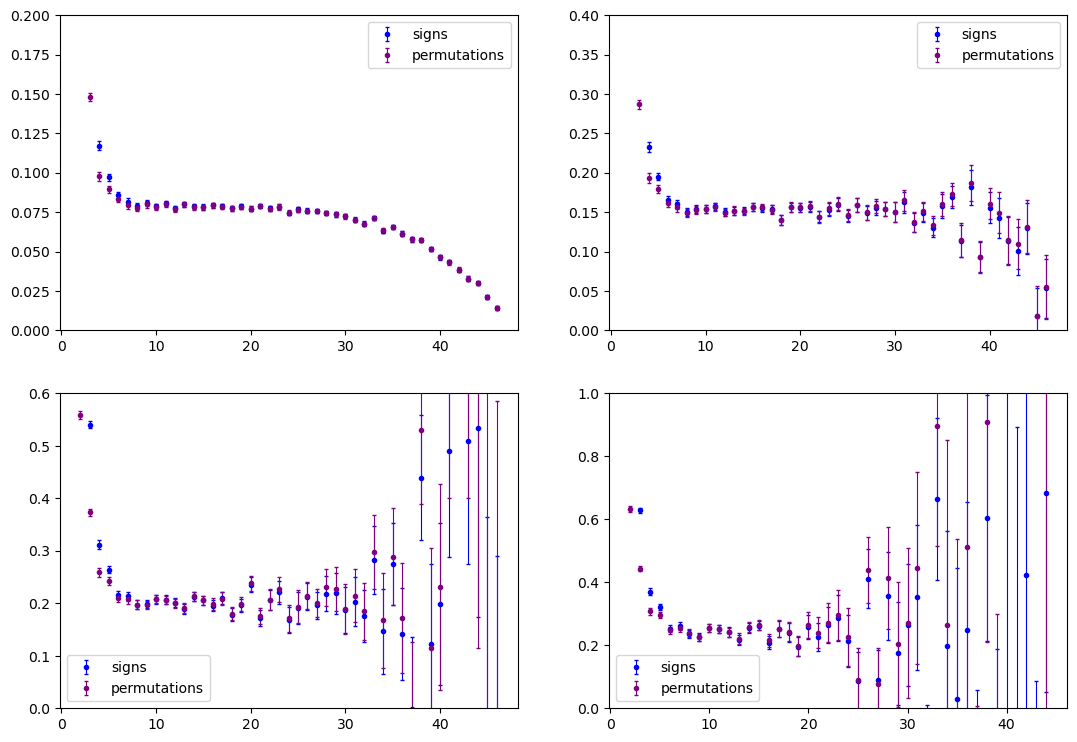

In [209]:
X31 = np.linspace(2,46,45)
fig31, ax31 = plt.subplots(2,2,figsize=(13,9))
ax31[0,0].errorbar(X31, em000_avg[1:46].real, yerr=em000_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="signs")
ax31[0,0].errorbar(X31, em_sym_000_avg[1:46].real, yerr=em_sym_000_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="permutations")
ax31[0,0].set_ylim(0,0.2)
ax31[0,0].legend();

ax31[0,1].errorbar(X31, em001_avg[1:46].real, yerr=em001_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="signs")
ax31[0,1].errorbar(X31, em_sym_001_avg[1:46].real, yerr=em_sym_001_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="permutations")
ax31[0,1].set_ylim(0.0,0.4)
ax31[0,1].legend();

ax31[1,0].errorbar(X31, em011_avg[1:46].real, yerr=em011_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="signs")
ax31[1,0].errorbar(X31, em_sym_011_avg[1:46].real, yerr=em_sym_011_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="permutations")
ax31[1,0].set_ylim(0.0,0.6)
ax31[1,0].legend();

ax31[1,1].errorbar(X31, em111_avg[1:46].real, yerr=em111_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="signs")
ax31[1,1].errorbar(X31, em_sym_111_avg[1:46].real, yerr=em_sym_111_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="permutations")
ax31[1,1].set_ylim(0.0,1)
ax31[1,1].legend();

In [113]:
E000_sym, E000_sym_err, A000, A000_err, chi = meson_energy(sym_000,sym_000_err,10,30)
E001_sym, E001_sym_err, A001, A001_err, chi = meson_energy(sym_001,sym_001_err,10,30)
E011_sym, E011_sym_err, A011, A011_err, chi = meson_energy(sym_011,sym_011_err,10,30)
E111_sym, E111_sym_err, A111, A111_err, chi = meson_energy(sym_111,sym_111_err,10,30)

In [114]:
e000_avg,e000_err = jack(np.array(E000_sym))
e001_avg,e001_err = jack(np.array(E001_sym))
e011_avg,e011_err = jack(np.array(E011_sym))
e111_avg,e111_err = jack(np.array(E111_sym))

In [207]:
E000_sym, E000_sym_err2, E000_sym_jk, chi2_dof000 = meson_energy_new(sym_000,10,30)
E001_sym, E001_sym_err2, E001_sym_jk, chi2_dof001 = meson_energy_new(sym_001,10,30)
E011_sym, E011_sym_err2, E011_sym_jk, chi2_dof011 = meson_energy_new(sym_011,10,30)
E111_sym, E111_sym_err2, E111_sym_jk, chi2_dof111 = meson_energy_new(sym_111,10,30)

In [232]:
E, E_err = jack(np.array(E011_sym_jk))

In [235]:

#np.array(E001_sym_jk) - np.array(E001_jk)
#np.array(E011_sym_jk) - np.array(E011_jk)
jack(np.array(E000_sym_jk) - np.array(E000_jk))

(np.float64(-2.3367837959396704e-05), np.float64(2.4070850975270934e-05))

In [208]:
print("full symmeterization")
print(f"E(0,0,0): {E000_sym} +/- {E000_sym_err2}")
print(f"E(0,0,1): {E001_sym} +/- {E001_sym_err2}")
print(f"E(0,1,1): {E011_sym} +/- {E011_sym_err2}")
print(f"E(1,1,1): {E111_sym} +/- {E111_sym_err2}")

full symmeterization
E(0,0,0): 0.08072614693389844 +/- 0.0001382486307989502
E(0,0,1): 0.15386103601946902 +/- 0.0003801970008623133
E(0,1,1): 0.20192175078213034 +/- 0.0009480519964541883
E(1,1,1): 0.24022060660460023 +/- 0.0020204835794733755


In [178]:
print("sign symmeterization")
print(f"E(0,0,0): {E000_abs} +/- {E000_abs_err2}")
print(f"E(0,0,1): {E001_abs} +/- {E001_abs_err2}")
print(f"E(0,1,1): {E011_abs} +/- {E011_abs_err2}")
print(f"E(1,1,1): {E111_abs} +/- {E111_abs_err2}")

sign symmeterization
E(0,0,0): 0.08072750084220505 +/- 0.00013844613136198942
E(0,0,1): 0.15386086208464486 +/- 0.0003829239059957196
E(0,1,1): 0.20192240715153922 +/- 0.0009575745146426081
E(1,1,1): 0.24030559433279192 +/- 0.002042326465663781


In [163]:
print("no symmeterization")
print(f"E(0,0,0): {E000} +/- {E000_err2}")
print(f"E(0,0,1): {E001} +/- {E001_err2}")
print(f"E(0,1,1): {E011} +/- {E011_err2}")
print(f"E(1,1,1): {E111} +/- {E111_err2}")

no symmeterization
E(0,0,0): 0.08073496802044046 +/- 0.0001368467388774598
E(0,0,1): 0.1537637512164445 +/- 0.00039121438235480675
E(0,1,1): 0.20195624410491606 +/- 0.0010255422919984208
E(1,1,1): 0.24096660939540768 +/- 0.0022107381935072353


In [133]:
np.array(E000_sym_jk) - np.array(E000_jk)

array([-0.00105645, -0.0010605 , -0.00105901, -0.00106002, -0.00105711,
       -0.00106152, -0.00105942, -0.00106321, -0.00105977, -0.00106155,
       -0.0010639 , -0.00105802, -0.00106428, -0.00106092, -0.00106065,
       -0.00106131, -0.00105862, -0.0010594 , -0.00105831, -0.00105974,
       -0.00106379, -0.00106456, -0.00106102, -0.00105555, -0.00105966,
       -0.00105991, -0.00105555, -0.00106554, -0.0010601 , -0.00105728,
       -0.00105784, -0.00105605, -0.00106222, -0.00106294, -0.0010605 ,
       -0.00105965, -0.00106261, -0.00106075, -0.00105778, -0.00106142,
       -0.00105901, -0.00105937, -0.00106386, -0.00106328, -0.00105554,
       -0.00105907, -0.00106508, -0.00105839, -0.00105863, -0.00106092,
       -0.00105963, -0.00106117, -0.00105784, -0.00105869, -0.00106334,
       -0.00105816, -0.00106004, -0.00105835, -0.00106176, -0.00105958,
       -0.00106589, -0.00105853, -0.00106332, -0.0010616 , -0.00106058,
       -0.00106143, -0.00106099, -0.0010606 , -0.00105746, -0.00

In [ ]:
np.array(E000_sym_jk) - np.array(E000_jk)

In [151]:
E_sym = [(E000_sym*a_inv)**2, (E001_sym*a_inv)**2, (E011_sym*a_inv)**2, (E111_sym*a_inv)**2]
E_sym_err = [E000_sym_err2, E001_sym_err2, E011_sym_err2, E111_sym_err2]
E_abs = [(E000_abs*a_inv)**2, (E001_abs*a_inv)**2, (E011_abs*a_inv)**2, (E111_abs*a_inv)**2]
E_abs_err = [E000_abs_err2, E001_abs_err2, E011_abs_err2, E111_abs_err2]
E = [(E000*a_inv)**2,(E001*a_inv)**2,(E011*a_inv)**2,(E111*a_inv)**2]
E_err = [E000_err2, E001_err2, E011_err2, E111_err2]

modes = np.arange(4)

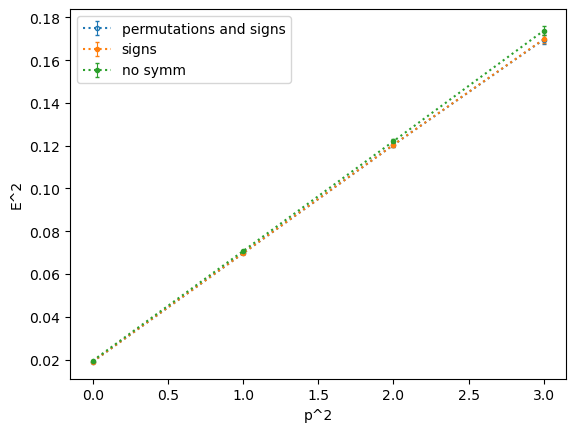

In [157]:
fig32, ax32 = plt.subplots()
ax32.errorbar(modes, E_sym, yerr=E_sym_err, marker = '.', ls=':',mfc="none",elinewidth=0.8,capsize=1.5,label="permutations and signs")
ax32.errorbar(modes, E_abs, yerr=E_abs_err, marker = '.', ls=':',elinewidth=0.8,capsize=1.5,label="signs")
ax32.errorbar(modes, E, yerr=E_err, marker = '.', ls=':',elinewidth=0.8,capsize=1.5,label="no symm")

#ax32.errorbar(modes, E, yerr=E_err, marker = '.', ls=':',elinewidth=0.8,capsize=1.5,label="no symmeterization")
#ax32.plot(mode, E_ac,marker='.',ls=':',label="E^2 = m^2 + p^2")
ax32.set_ylabel("E^2")
ax32.set_xlabel("p^2")
#ax4.set_xticks(modes)
ax32.legend()

### Correlator comparison between methods

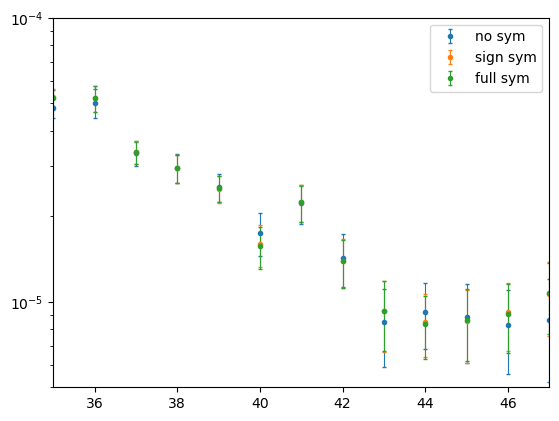

In [226]:
X31 = np.linspace(0,47,48)
fig31,ax31 = plt.subplots()

ax31.errorbar(X31,pi_011_avg[1:49].real,yerr=pi_011_err[1:49].real,marker=".",ls="",elinewidth=0.8,capsize=1.5,label="no sym")
ax31.errorbar(X31, jp011_avg[1:].real, yerr=jp011_err[1:].real, marker=".",ls="",elinewidth=0.8,capsize=1.5,label="sign sym")
ax31.errorbar(X31, sym_011_avg[1:].real, yerr=sym_011_err[1:].real, marker=".",ls="",elinewidth=0.8,capsize=1.5,label="full sym")


ax31.set_yscale("log")
ax31.set_xlim(35,47)
ax31.set_ylim(5e-6,1e-4)
ax31.legend();

### Method 5: unbinned time direction (identical), No probability (identical)

In [2215]:
dst_list = []
prefix3 = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-pos-noprob/"

#for cf in range(1005,1096,10):
#    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(1102,1493,10):
#    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

for cf in range(1102,1293,10):
    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(1322,1392,10):
#    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(1412,1492,10):
#    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(1322,1392,10):
#    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(1412,1492,10):
#    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(1505,1635,10):
#    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(1705,1895,10):
#    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(1905,2026,10):
#    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

#for cf in range(2085,2176,10):
#    dst_list.append(prefix3+f"traj-{cf}/meson_corr_psnk_psrc_psel.lat")

In [2216]:
ncf = len(dst_list)
allconf_pos_nt = []
for i in range(ncf):
    allconf_pos_nt.append(q.load_lat_data(dst_list[i]).to_numpy()[:,:,:,:,:2])

In [2217]:
pp_nt_corr = np.array(allconf_pos_nt)[:,:,:,:,:,1]
pp_nt_delta = np.array(allconf_pos_nt)[:,:,:,:,:,0]

In [2218]:
pp_nt_corr.shape

(20, 25, 25, 25, 49)

In [2219]:
j_nt = jackblocks_ratio(pp_nt_corr.real,pp_nt_delta.real,omit=[])

In [2220]:
p000_nt = mom_project_half(j_nt.real,mode=0)
p001_nt = mom_project_half(j_nt.real,mode=1)
p011_nt = mom_project_half(j_nt.real,mode=2)
p111_nt = mom_project_half(j_nt.real,mode=3)

jnt000_avg,jnt000_err = jack(p000_nt)
jnt001_avg,jnt001_err = jack(p001_nt)
jnt011_avg,jnt011_err = jack(p011_nt)
jnt111_avg,jnt111_err = jack(p111_nt)

In [2221]:
jnt000_avg.shape

(49,)

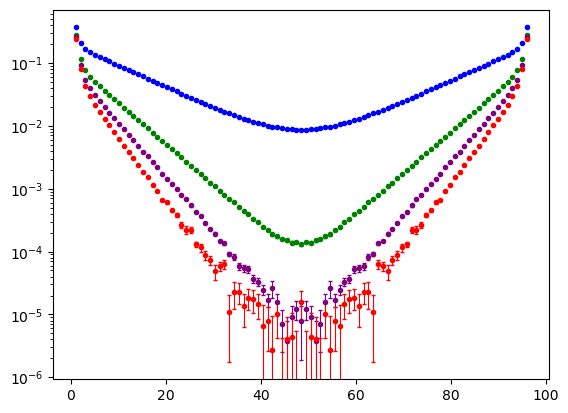

In [2144]:
X24 = np.linspace(1,96,95)
fig24, ax24 = plt.subplots()
ax24.errorbar(X24, jnp000_avg[1:].real, yerr=jnp000_err[1:].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5)
ax24.errorbar(X24, jnp001_avg[1:].real, yerr=jnp001_err[1:].real, marker=".",color="green",ls="",elinewidth=0.8,capsize=1.5)
ax24.errorbar(X24, jnp011_avg[1:].real, yerr=jnp011_err[1:].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5)
ax24.errorbar(X24, jnp111_avg[1:].real, yerr=jnp111_err[1:].real, marker=".",color="red",ls="",elinewidth=0.8,capsize=1.5)
ax24.set_yscale("log")

In [2222]:
em_nt_000 = eff_mass_2d_ln(p000_nt.real)
em_nt_001 = eff_mass_2d_ln(p001_nt.real)
em_nt_011 = eff_mass_2d_ln(p011_nt.real)
em_nt_111 = eff_mass_2d_ln(p111_nt.real)

emnp000_avg, emnp000_err = jack(em_nt_000)
emnp001_avg, emnp001_err = jack(em_nt_001)
emnp011_avg, emnp011_err = jack(em_nt_011)
emnp111_avg, emnp111_err = jack(em_nt_111)

In [2153]:
p000_nt.shape

(40, 96)

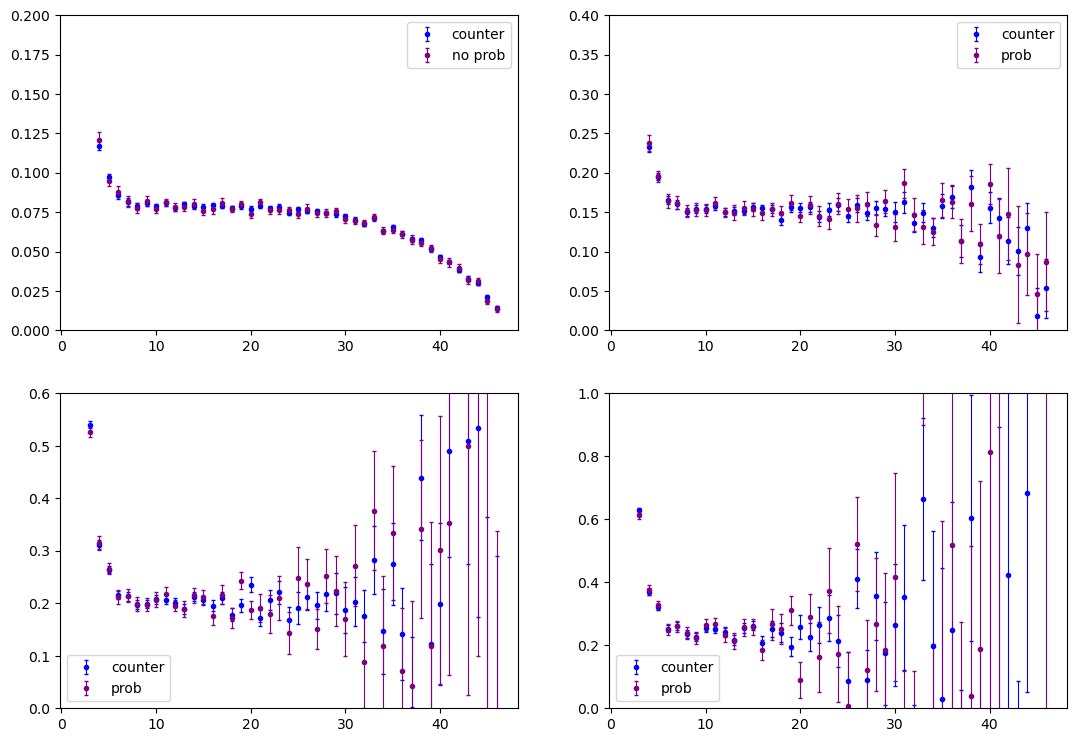

In [2177]:
X25 = np.linspace(2,46,45)
fig25, ax25 = plt.subplots(2,2,figsize=(13,9))
ax25[0,0].errorbar(X25, em000_avg[1:46].real, yerr=em000_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="counter")
ax25[0,0].errorbar(X25, emnp000_avg[1:46].real, yerr=emnp000_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="no prob")
ax25[0,0].set_ylim(0,0.2)
ax25[0,0].legend();

ax25[0,1].errorbar(X25, em001_avg[1:46].real, yerr=em001_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="counter")
ax25[0,1].errorbar(X25, emnp001_avg[1:46].real, yerr=emnp001_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="prob")
ax25[0,1].set_ylim(0.0,0.4)
ax25[0,1].legend();

ax25[1,0].errorbar(X25, em011_avg[1:46].real, yerr=em011_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="counter")
ax25[1,0].errorbar(X25, emnp011_avg[1:46].real, yerr=emnp011_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="prob")
ax25[1,0].set_ylim(0.0,0.6)
ax25[1,0].legend();

ax25[1,1].errorbar(X25, em111_avg[1:46].real, yerr=em111_err[1:46].real, marker=".",color="blue",ls="",elinewidth=0.8,capsize=1.5,label="counter")
ax25[1,1].errorbar(X25, emnp111_avg[1:46].real, yerr=emnp111_err[1:46].real, marker=".",color="purple",ls="",elinewidth=0.8,capsize=1.5,label="prob")
ax25[1,1].set_ylim(0.0,1)
ax25[1,1].legend();

In [2223]:
E000_nt, E000_nt_err2, E000_nt_jk, chi2_dof_000 = meson_energy_new(p000_nt,10,30)
E001_nt, E001_nt_err2, E001_nt_jk, chi2_dof_001 = meson_energy_new(p001_nt,10,30)
E011_nt, E011_nt_err2, E001_nt_jk, chi2_dof_011 = meson_energy_new(p011_nt,10,30)
E111_nt, E111_nt_err2, E111_nt_jk, chi2_dof_111 = meson_energy_new(p111_nt,10,30)

In [1752]:
E000_np_avg, E000_np_err2 = jack(np.array(E000_np))
E001_np_avg, E001_np_err2 = jack(np.array(E001_np))
E011_np_avg, E011_np_err2 = jack(np.array(E011_np))
E111_np_avg, E111_np_err2 = jack(np.array(E111_np))

In [2224]:
print("Unbinned time direction")
print(f"(0,0,0) pion energy fit: {E000_nt} +/- {E000_nt_err2}")
print(f"(0,0,1) state pion energy fit: {E001_nt} +/- {E001_nt_err2}")
print(f"(0,1,1) state pion energy fit: {E011_nt} +/- {E011_nt_err2}")
print(f"(1,1,1) state pion energy fit: {E111_nt} +/- {E111_nt_err2}")

Unbinned time direction
(0,0,0) pion energy fit: 0.07942065179576245 +/- 0.0003315244098754146
(0,0,1) state pion energy fit: 0.15312764856730354 +/- 0.0009469476725033475
(0,1,1) state pion energy fit: 0.201445393325155 +/- 0.0022346270652492555
(1,1,1) state pion energy fit: 0.23633315715939443 +/- 0.004696441801710343


In [2225]:
print("binned time direction")
print(f"position space ground state pion energy fit: {E000_abs} +/- {E000_abs_err2}")
print(f"position space ground state pion energy fit: {E001_abs} +/- {E001_abs_err2}")
print(f"position space ground state pion energy fit: {E011_abs} +/- {E011_abs_err2}")
print(f"position space ground state pion energy fit: {E111_abs} +/- {E111_abs_err2}")

binned time direction
position space ground state pion energy fit: 0.07942065179726393 +/- 0.00033152439651366834
position space ground state pion energy fit: 0.1531276485924355 +/- 0.0009469476677645113
position space ground state pion energy fit: 0.20144539332697303 +/- 0.0022346269032997423
position space ground state pion energy fit: 0.23633315712794062 +/- 0.004696441523018265


Through 20 configurations we see that the data are identical whether we divide by probability or not in the calculation of the position space correlation function